<center><h2>MAP473D : Simulation numérique aléatoire</h2>
    <h4>Risque de défaut d'entreprises</h4></center><br>
<b>Groupe 1 :</b> Outhmane Itro & Yassine Ettachfini<br> <br>
Nous nous intéresserons à <b>l’estimation et la quantification du risque de défaut de crédit</b> d’entreprises et d’emetteur dans un portefeuille d’actifs. La difficulté étant d’estimercorrectement différentes métriques de risques quand l’événement de défaut d’un ou deplusieurs entreprises devient très rare. <br><br>
Nous commencerons pour cela par étudier le cas dedébiteurs (ou entreprises) indépendants puis le cas où nos actifs seraient corrélés et étudierons l’effet de cette corrélation ainsi que d’autres paramètres (volatilité des actifs <b>$\sigma$</b>, seuil de défaut <b>$B$</b>...) sur les risques de défaut de crédit.

In [1085]:
#Les modules utilisés pour le projet

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy as sp
import seaborn as sns
import matplotlib

# Pour les barres de chargement
from tqdm.notebook import tqdm, trange

# Setting plotting style
sns.set_style("darkgrid")
matplotlib.rcParams.update({'font.size': 15})

import warnings
warnings.filterwarnings('ignore')

### Introduction 
On commence par réaliser un code qui permet de visualiser les trajectoires des actifs pour différents paramètres. Cette fonction GBM permet d'afficher et obtenir une réalisation d'évolution d'un nombre N d'entreprise sur un horizon temporel de 1 an pour une volatilité et seuil de défaut fixé.

In [1086]:
def GBM(S0 = 100,sigma = 0.4,DT=365,pShow = 1,NbrEnt = 125,nbrShow = -1,B=36,show = False,rho=0):
    '''
    S0      : Valeur initiale des actifs (125 par défaut)
    sigma   : volatilité des actifs (0.4 par défaut)
    DT      : nombre de subdivions de l'horizon temporel (365 par défaut)
    B       : Seuil de défaut (36 par défaut)
    NbrEnt  : Nombre d'entreprise (5 par défaut)
    NbrShow : Nombre d'entreprise à visualiser dans le graphe (5 par défaut)
    rho     : Coefficient de correlation des entreprises (0.0 par défaut)
    show    : True pour afficher un graphique de l'évolution des actifs False sinon
    pShow   : Portion du domaine temporel à afficher (1 par défaut)
    '''
    if nbrShow == -1 or nbrShow > NbrEnt :
        nbrShow = NbrEnt
    limitT = DT
    timeSee = int(np.floor(limitT*pShow))
    T = np.array([i*(1/limitT) for i in range(limitT)])
    displayT = DT*T
    S = np.random.normal(loc=0.0, scale=1.0,size=(limitT-1,NbrEnt+1))*(1/np.sqrt(limitT))
    Matrix = np.eye(NbrEnt+1)
    for i in range(1,NbrEnt+1):
        Matrix[i,0] = np.sqrt(rho)
        Matrix[i,i] *= np.sqrt(1-rho) 
    S = np.transpose(np.array([Matrix.dot(S[i]) for i in range(S.shape[0])]))
    S = np.array([np.append([0],np.cumsum(S[i,:])) for i in range(NbrEnt)])
    Var = np.array([[ -0.5*sigma*sigma*T[i] for i in range(limitT)] for j in range(NbrEnt)])
    S = sigma*S
    S = S0*np.exp(S+Var)
    plt.figure(figsize=(15,7))
    if show:
        for i in range(nbrShow):
            plt.plot(displayT,S[i,:timeSee])
        plt.xlabel('t')
        plt.ylabel(r"$S^i_t$ valeur de l'entreprise")
        plt.axhline(B)
        plt.show()
    return S

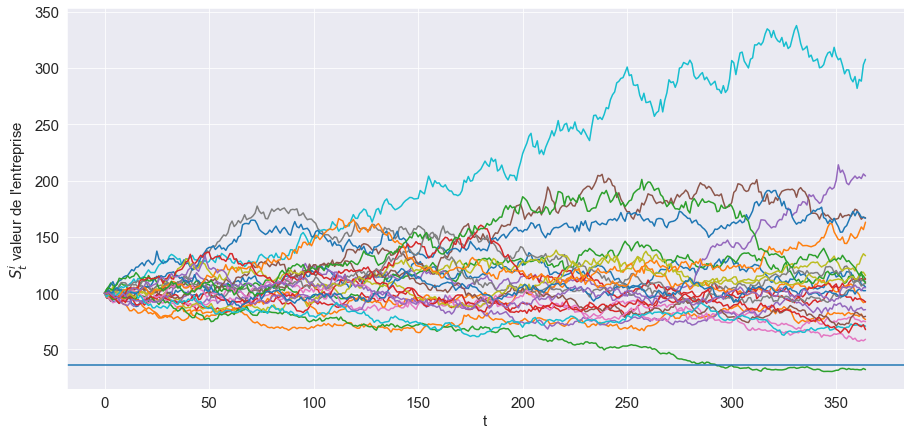

In [1087]:
Result = GBM(show=True,DT=365,NbrEnt = 25,rho = 0)


Avec notre première définition du défaut évalué exactement à l'instant $T=1$, on en remarque que notre problème revient à étudier non plus des processus continues mais simplement un vecteur gaussien $\mathcal{N}(0,I)$(cas indépendants) ou $\mathcal{N}(0,\Gamma)$(cas dépendants avec $\Gamma$ matrice de covariance donnée). Le vecteur en question est  $\left(W_T^1, ... , W_T^N\right)$

<h3>Partie I : Cas de débiteurs indépendants</h3> <br>
On suppose dans cette partie que les entreprises évoluent de façon indépendante. On peut donc écrire notre variable $L$ comme :
$$
 L = \sum_{i=1}^{N} \mathbb{1}_{\{S_T^i \leq B\}}
$$
Avec les $\left(\mathbb{1}_{\{S_T^i \leq B\}}\right)_{ 1 \leq i \leq N}$ sont des variables de bernoulli indépendantes et de même paramètre $ p = \mathbb{P}\left(Z \leq M_{(B,\sigma)}\right)$ avec $M_{(B,\sigma)} = \frac{1}{\sigma}\log(B) - \frac{\sigma}{2}\log(S_0)$ où Z suit une loi normale centrée réduite.

On en déduit que $L$ suit une loi binomiale de paramètre N = 125, $ p = \mathbb{P}\left(Z \leq M_{(B,\sigma)}\right)$ avec $M_{(B,\sigma)} = \frac{1}{\sigma}\log(B) - \frac{\sigma}{2}\log(S_0)$.<br>
On en déduit qu'il suffit d'estimer le paramètre $p$ pour retrouver la distribution de $L$ (et donc les $\mathbb{P}\left(L \geq k\right)$ pour tout $k$). <br><br>
On compare cette estimation à la distribution théorique et à une méthode naïve de Monte Carlo ainsi qu'une méthode d'Importance Sampling par changement de moyenne pour de la variable gaussienne centrée réduite $\left(W_1, ... , W_N\right)$ . <br>
Pour chaque $k$, on effectue des changements de moyenne différents. Pour réduire la complexité de notre espace de recherche de paramètres, et donc de notre moyenne, on l'écrira sous la forme de fonctions d'une ou deux variables au plus. On nous réduira donc à la séléction d'éléments dans un espace de dimension 125 à des espaces de dimensions 1 ou 2.<br><br>
On remarque que pour la méthode d'IS. L'estimation est beaucoup moins précise que pour les autres méthodes, ce qui s'expliquerait par une variance accrue de l'estimateur aggrandissant donc les intervalles de confiance. On remarque aussi que l'estimation tombe à zéro également à partir d'un certain $k$, ce qui est normal car les événements estimés restent également très rares. Par exemple pour $k = 125$, la probabilité de notre événement sous notre nouvelle loi est de $\left(\frac{1}{2}\right)^{125} \approx 2.10^{-38} <<< 10^{-4}$

#### Distribution de L :

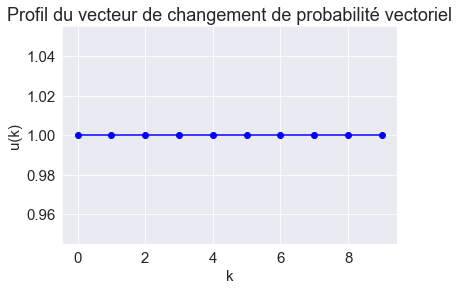

In [1088]:
N = 10
plt.plot(range(N),[1]*N,'bo-',label="profil de u")
plt.xlabel(r'k')
plt.ylabel(r'u(k)')
plt.title("Profil du vecteur de changement de probabilité vectoriel")
plt.show()

Par estimation de p = P(W < mean)



Valeur théorique de p = P(W<W_0) =  0.009283105350599749
Probabilité estimée par Monte Carlo : p_MC =  0.00903
Rayon Ic =  0.0005863031395218314
Intervale de confiance MC : [ 0.008443696860478168 , 0.009616303139521831 ]
Probabilité estimée par IS : p_IS =  0.00925480506446926
Rayon Ic =  9.462187400329392e-05
intervale de confiance IS [ 0.009160183190465965 , 0.009349426938472554 ]

Méthode naïve MC



Première méthode d'Importance Sampling


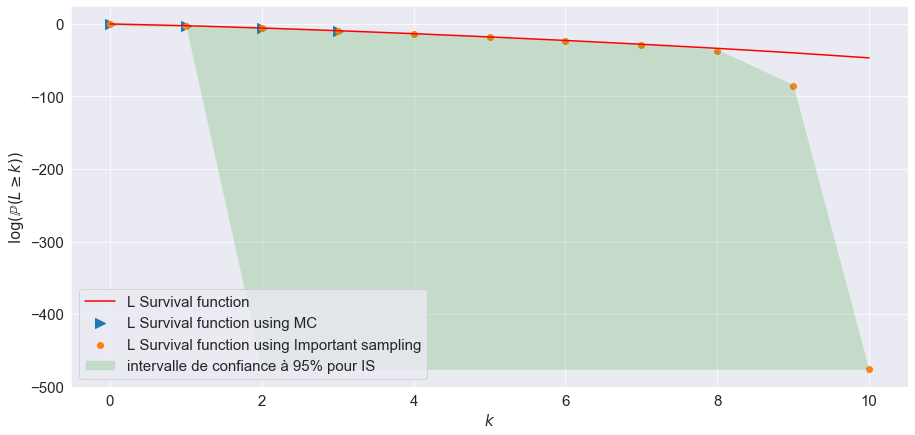

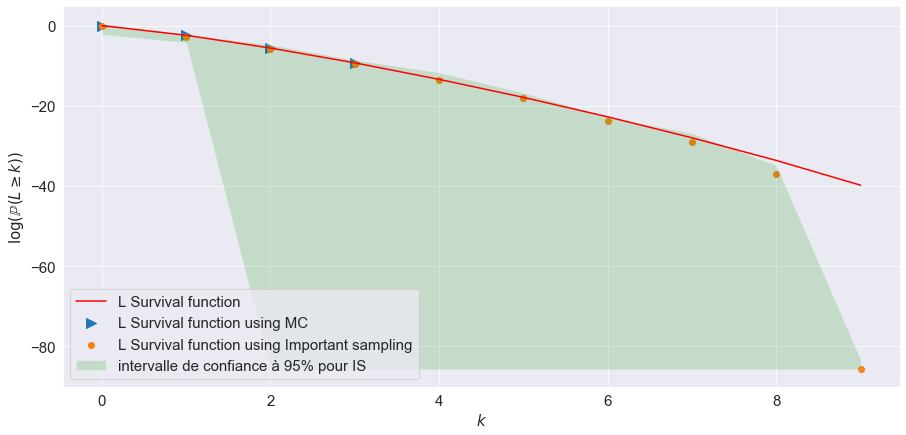

In [1067]:
'''
IS en utilisant le profil ci dessus
'''
N = 10 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e5)
B = 36
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
q = sps.norm.ppf(0.975)

# Valeurs théoriques des probabilités -------------------------------------------------------

p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)
fBin = sps.binom.sf(espace,N,p)
espace = espace + 0.1

# Par estimation de p = P(W < mean) ---------------------------------------------------------
Y = np.random.normal(0,1,size=M)
p_MC = np.mean(Y<mean)
p_es = np.mean(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))


probas_IS=[]
probas_MC = []
print("Par estimation de p = P(W < mean)")
pbar = tqdm(total=N)
for k in range(N+1):
    proba1 = 0.0
    proba2 = 0.0
    for i in range(k,N+1):
        proba1+= p_es**i*(1-p_es)**(N-i)*sp.special.binom(N,i)
        proba2+= p_MC**i*(1-p_MC)**(N-i)*sp.special.binom(N,i)
    probas_IS.append(proba1)
    probas_MC.append(proba2)
    pbar.update(1)
pbar.close()
print("Valeur théorique de p = P(W<W_0) = ",p)
print("Probabilité estimée par Monte Carlo : p_MC = ", p_MC)
std_MC = np.std(Y<mean)*q/(np.sqrt(M))
print('Rayon Ic = ',std_MC)
print("Intervale de confiance MC : [",p_MC-std_MC,',',p_MC+std_MC,']')
print("Probabilité estimée par IS : p_IS = ", p_es)
std_IS = np.std(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))*q/(np.sqrt(M))
print('Rayon Ic = ',std_IS)
print("intervale de confiance IS [",p_es-std_IS,',',p_es+std_IS,']\n')

# Méthode naïve MC  -------------------------------------------------------------------------

P = []
vect_std_mc = []
W = np.random.normal(size=(M,N))
S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])
L = np.sum(S <= B,axis = 1)
print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    vect_std_mc.append(np.std(L >= k)*q*(1/np.sqrt(M)))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling-----------------------------------------------------

# tenter petites perturbations autour de 0 d'abord
P_IS = []
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = []
PD = []
#boxes = []
mean0 = 0 # à commenter si besoin
for k in range(N+1):
    #q = min(int(np.ceil(k*np.log(k+1))),N)  # à commenter si besoin
    q = N  # à commenter si besoin
    mean0 = -1/(1-k/(N+1)) # à commenter si besoin
    W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,1,size=(M,N-q)),axis=1)
    L = np.sum(W <= mean,axis = 1)
    res = (L >= k)*np.exp(-np.sum(W[:,:q],axis=1)*mean0+0.5*(q)*mean0*mean0)
    mu = np.mean(res)
    #boxes.append(res.copy())
    P_IS.append(mu)
    standartD = np.std(res)
    si =  np.std(res)*q*(1/np.sqrt(M))
    #s1 = ((1+3*(q-standartD/(6*M)))**(1/3)-1)*standartD*(1/np.sqrt(M))
    #s2 = ((1+3*(-q-standartD/(6*M)))**(1/3)-1)*standartD*(1/np.sqrt(M))
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()
#plt.boxplot(boxes)
#plt.show()

# Préparation des np.arrays -----------------------------------------------------------------

Stop_MC = 0
while  Stop_MC < N and P[Stop_MC] != 0:
    Stop_MC+=1


# Calcul du premier k non calculé par MC 

P = np.array(P)
P_IS = np.array(P_IS)
probas_IS = np.array(probas_IS)
probas_MC = np.array(probas_MC)
PH = np.array(PH)
PD = np.array(PD)

h = min(np.min(P_IS[P_IS>0]),np.min(fBin))
PD2 = []
for i in range(len(PD)):
    if PD[i] <= 0.0:
        PD2.append(h)
    else : 
        PD2.append(PD[i])

# Affichage des courbes ---------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.scatter(range(N+1),np.log(P),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(N+1),np.log(P_IS),label="L Survival function using Important sampling")
plt.plot(espace,np.log(fBin),'r-',label="L Survival function")
plt.fill_between(range(N+1), np.log(PD2), np.log(PH), alpha=0.2, 
                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
limit = max(N//10,10)

h = min(np.min(P_IS[:limit][P_IS[:limit]>0]),np.min(fBin))
PD3 = []
for i in range(limit):
    if PD[i] <= 0.0:
        PD3.append(h)
    else : 
        PD3.append(PD[i])
plt.scatter(range(limit),np.log(P[:limit]),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(limit),np.log(P_IS[:limit]),label="L Survival function using Important sampling")
plt.plot(range(limit),np.log(fBin[:limit]),'r-',label="L Survival function")
plt.fill_between(range(limit), np.log(PD3[:limit]), np.log(PH[:limit]), alpha=0.2, 
                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

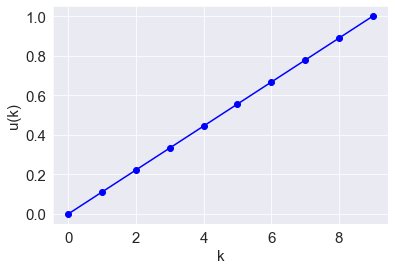

In [1007]:
N = 10
plt.plot(range(N),[i/(N-1) for i in range(N)],'bo-',label="profil de u")
plt.xlabel(r'k')
plt.ylabel(r'u(k)')
#plt.title("Profil du vecteur de changement de probabilité vectoriel")
plt.show()

Par estimation de p = P(W < mean)



Valeur théorique de p = P(W<W_0) =  0.009283105350599749
Probabilité estimée par Monte Carlo : p_MC =  0.0108
Intervale de confiance MC : [ 0.008774137325088397 , 0.012825862674911604 ]
Probabilité estimée par IS : p_IS =  0.00932203101200397
intervale de confiance IS [ 0.009023158478610974 , 0.009620903545396967 ]

Méthode naïve MC



Première méthode d'Importance Sampling


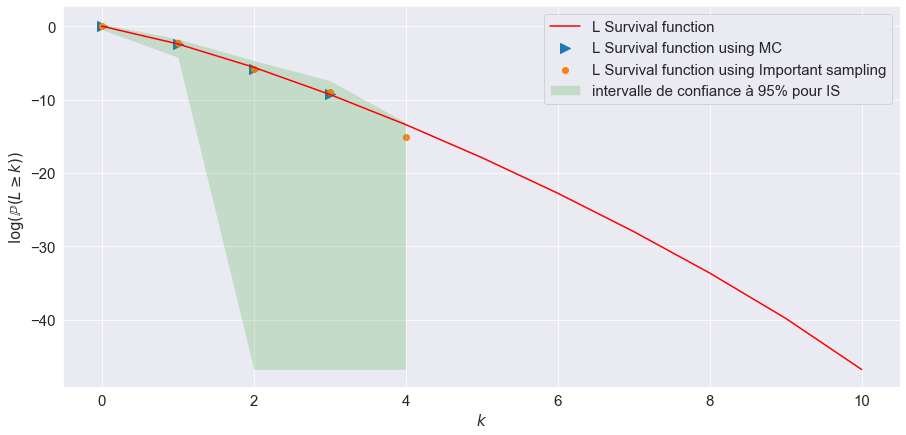

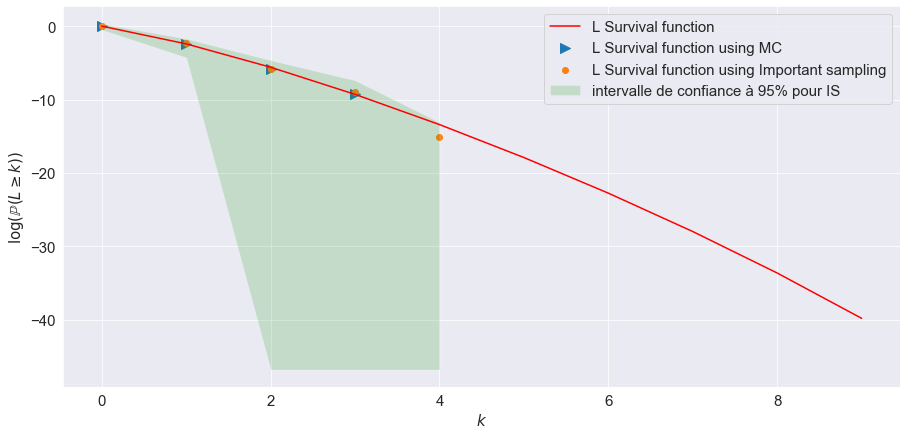

In [1069]:
'''
IS en utilisant le profil ci dessus
'''

N = 10 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e4)
B = 36
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
q = sps.norm.ppf(0.99)
# Valeurs théoriques des probabilités -------------------------------------------------------

p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)
fBin = sps.binom.sf(espace,N,p)
espace = espace + 0.1

# Par estimation de p = P(W < mean) ---------------------------------------------------------
Y = np.random.normal(0,1,size=M)
p_MC = np.mean(Y<mean)
p_es = np.mean(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))


probas_IS=[]
probas_MC = []
print("Par estimation de p = P(W < mean)")
pbar = tqdm(total=N)
for k in range(N+1):
    proba1 = 0.0
    proba2 = 0.0
    for i in range(k,N+1):
        proba1+= p_es**i*(1-p_es)**(N-i)*sp.special.binom(N,i)
        proba2+= p_MC**i*(1-p_MC)**(N-i)*sp.special.binom(N,i)
    probas_IS.append(proba1)
    probas_MC.append(proba2)
    pbar.update(1)
pbar.close()
print("Valeur théorique de p = P(W<W_0) = ",p)
print("Probabilité estimée par Monte Carlo : p_MC = ", p_MC)
std = np.std(Y<mean)
print("Intervale de confiance MC : [",p_MC-1.96*std/(np.sqrt(M)),',',p_MC+1.96*std/(np.sqrt(M)),']')
print("Probabilité estimée par IS : p_IS = ", p_es)
std = np.std(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))
print("intervale de confiance IS [",p_es-1.96*std/(np.sqrt(M)),',',p_es+1.96*std/(np.sqrt(M)),']\n')

# Méthode naïve MC  -------------------------------------------------------------------------

P = []
W = np.random.normal(size=(M,N))
S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])
L = np.sum(S <= B,axis = 1)
print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling-----------------------------------------------------

# tenter petites perturbations autour de 0 d'abord
P_IS = []
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = []
PD = []
#boxes = []
mean0 = 0 # à commenter si besoin
for k in range(N+1):
    #q = min(int(np.ceil(k*np.log(k+1))),N)  # à commenter si besoin
    q = N  # à commenter si besoin
    mean0 = -1/(1-k**2/(N+1)**2)*np.array([i/N for i in range(N)]) # à commenter si besoin
    W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,1,size=(M,N-q)),axis=1)
    L = np.sum(W <= mean,axis = 1)
    res = (L >= k)*np.exp(-np.sum(W[:,:q]*mean0,axis=1)+0.5*np.sum(mean0*mean0))
    mu = np.mean(res)
    #boxes.append(res.copy())
    P_IS.append(mu)
    si = np.std(res)*q*(1/np.sqrt(M))
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()
#plt.boxplot(boxes)
#plt.show()

# Préparation des np.arrays -----------------------------------------------------------------

Stop_MC = 0
while  Stop_MC < N and P[Stop_MC] != 0:
    Stop_MC+=1


# Calcul du premier k non calculé par MC 

P = np.array(P)
P_IS = np.array(P_IS)
probas_IS = np.array(probas_IS)
probas_MC = np.array(probas_MC)
PH = np.array(PH)
PD = np.array(PD)

h = min(np.min(P_IS[P_IS>0]),np.min(fBin))
PD2 = []
for i in range(len(PD)):
    if PD[i] <= 0.0:
        PD2.append(h)
    else : 
        PD2.append(PD[i])

# Affichage des courbes ---------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.scatter(range(N+1),np.log(P),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(N+1),np.log(P_IS),label="L Survival function using Important sampling")
plt.plot(espace,np.log(fBin),'r-',label="L Survival function")
plt.fill_between(range(N+1), np.log(PD2), np.log(PH), alpha=0.2, 
                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
limit = max(N//10,10)

h = min(np.min(P_IS[:limit][P_IS[:limit]>0]),np.min(fBin))
PD3 = []
for i in range(limit):
    if PD[i] <= 0.0:
        PD3.append(h)
    else : 
        PD3.append(PD[i])
plt.scatter(range(limit),np.log(P[:limit]),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(limit),np.log(P_IS[:limit]),label="L Survival function using Important sampling")
plt.plot(range(limit),np.log(fBin[:limit]),'r-',label="L Survival function")
plt.fill_between(range(limit), np.log(PD3[:limit]), np.log(PH[:limit]), alpha=0.2, 
                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

if N > 20:
    plt.figure(figsize=(15,7))
    plt.plot(range(9,20),P[9:20],label="Survival function par MC")
    espace2 = np.arange(9-0.1,20-0.1)
    P2 = sps.binom.sf(espace2,N,p)
    espace2 = espace2 + 0.1
    plt.plot(espace2,P2,label="Survival function théorique")
    plt.title("MC fail when k <= 9")
    plt.legend()
    plt.show()

if N > 30:
    plt.figure(figsize=(15,7))
    plt.plot(range(20,30),P[20:30],label="Survival function par MC")
    espace3 = np.arange(20-0.1,30-0.1)
    P3 = sps.binom.sf(espace3,N,p)
    espace3 = espace3 + 0.1
    plt.plot(espace3,P3,label="Survival function théorique")
    plt.title("MC fail when k <= 9 (visualization in [20,30])")
    plt.legend()
    plt.show()

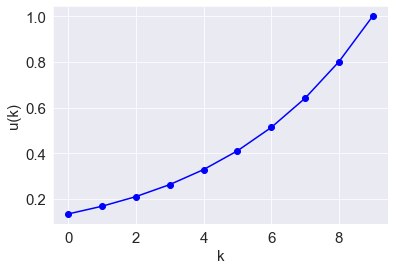

In [958]:
N = 10
a = 2
plt.plot(range(N),[np.exp(-a*(1-i/(N-1))) for i in range(N)],'bo-',label="profil de u")
plt.xlabel(r'k')
plt.ylabel(r'u(k)')
#plt.title("Profil du vecteur de changement de probabilité vectoriel")
plt.show()

2.3263478740408408
Par estimation de p = P(W < mean)



Valeur théorique de p = P(W<W_0) =  0.009283105350599749
Probabilité estimée par Monte Carlo : p_MC =  0.0088
Intervale de confiance MC : [ 0.006969464928060651 , 0.01063053507193935 ]
Probabilité estimée par IS : p_IS =  0.009361311495838342
intervale de confiance IS [ 0.009060155148750432 , 0.00966246784292625 ]

Méthode naïve MC



Première méthode d'Importance Sampling


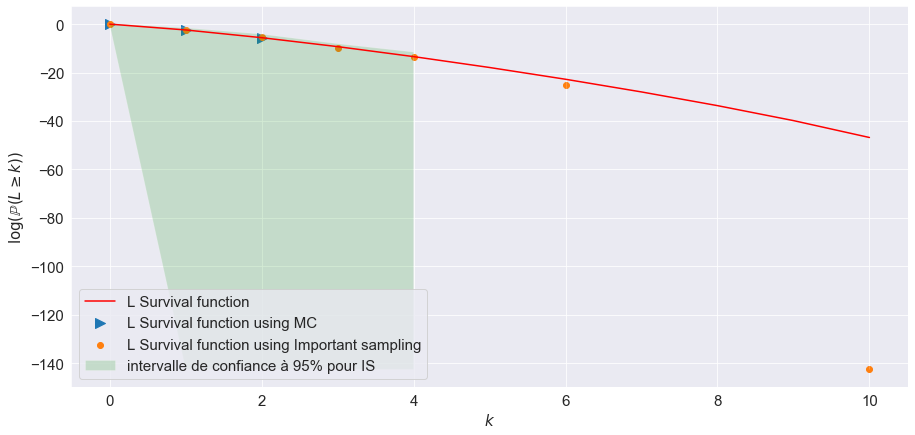

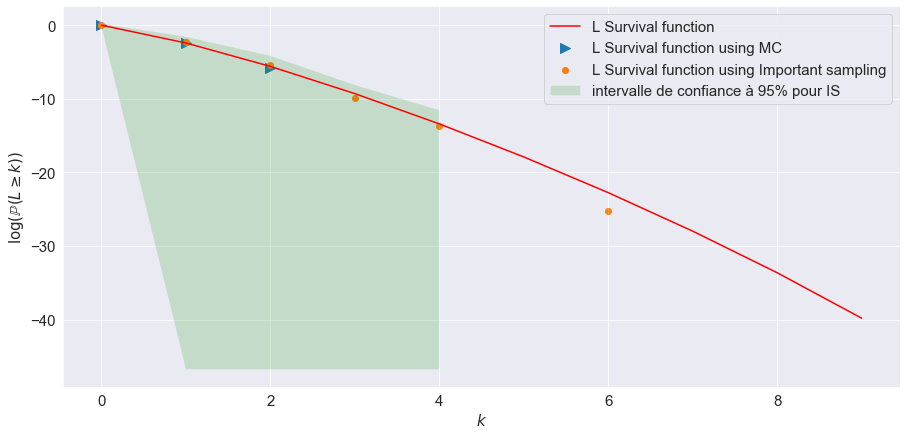

In [1070]:
'''
IS en utilisant le profil ci dessus
'''

N = 10 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e4)
B = 36
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
q = sps.norm.ppf(0.99)
print(q)
# Valeurs théoriques des probabilités -------------------------------------------------------

p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)
fBin = sps.binom.sf(espace,N,p)
espace = espace + 0.1

# Par estimation de p = P(W < mean) ---------------------------------------------------------
Y = np.random.normal(0,1,size=M)
p_MC = np.mean(Y<mean)
p_es = np.mean(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))


probas_IS=[]
probas_MC = []
print("Par estimation de p = P(W < mean)")
pbar = tqdm(total=N)
for k in range(N+1):
    proba1 = 0.0
    proba2 = 0.0
    for i in range(k,N+1):
        proba1+= p_es**i*(1-p_es)**(N-i)*sp.special.binom(N,i)
        proba2+= p_MC**i*(1-p_MC)**(N-i)*sp.special.binom(N,i)
    probas_IS.append(proba1)
    probas_MC.append(proba2)
    pbar.update(1)
pbar.close()
print("Valeur théorique de p = P(W<W_0) = ",p)
print("Probabilité estimée par Monte Carlo : p_MC = ", p_MC)
std = np.std(Y<mean)
print("Intervale de confiance MC : [",p_MC-1.96*std/(np.sqrt(M)),',',p_MC+1.96*std/(np.sqrt(M)),']')
print("Probabilité estimée par IS : p_IS = ", p_es)
std = np.std(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))
print("intervale de confiance IS [",p_es-1.96*std/(np.sqrt(M)),',',p_es+1.96*std/(np.sqrt(M)),']\n')

# Méthode naïve MC  -------------------------------------------------------------------------

P = []
W = np.random.normal(size=(M,N))
S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])
L = np.sum(S <= B,axis = 1)
print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling-----------------------------------------------------

# tenter petites perturbations autour de 0 d'abord
P_IS = []
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = []
PD = []
#boxes = []
mean0 = 0 # à commenter si besoin
for k in range(N+1):
    #q = min(int(np.ceil(k*np.log(k+1))),N)  # à commenter si besoin
    q = N  # à commenter si besoin
    mean0 = -1/(1-k/(N+1))*np.array([np.exp(-2.5*(i/(N-1))) for i in range(N)]) # à commenter si besoin
    W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,1,size=(M,N-q)),axis=1)
    L = np.sum(W <= mean,axis = 1)
    res = (L >= k)*np.exp(-np.sum(W[:,:q]*mean0,axis=1)+0.5*np.sum(mean0*mean0))
    mu = np.mean(res)
    #boxes.append(res.copy())
    P_IS.append(mu)
    si = np.std(res)*q*(1/np.sqrt(M))
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()
#plt.boxplot(boxes)
#plt.show()

# Préparation des np.arrays -----------------------------------------------------------------

Stop_MC = 0
while  Stop_MC < N and P[Stop_MC] != 0:
    Stop_MC+=1


# Calcul du premier k non calculé par MC 

P = np.array(P)
P_IS = np.array(P_IS)
probas_IS = np.array(probas_IS)
probas_MC = np.array(probas_MC)
PH = np.array(PH)
PD = np.array(PD)

h = min(np.min(P_IS[P_IS>0]),np.min(fBin))
PD2 = []
for i in range(len(PD)):
    if PD[i] <= 0.0:
        PD2.append(h)
    else : 
        PD2.append(PD[i])

# Affichage des courbes ---------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.scatter(range(N+1),np.log(P),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(N+1),np.log(P_IS),label="L Survival function using Important sampling")
plt.plot(espace,np.log(fBin),'r-',label="L Survival function")
plt.fill_between(range(N+1), np.log(PD2), np.log(PH), alpha=0.2, 
                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
limit = max(N//10,10)

h = min(np.min(P_IS[:limit][P_IS[:limit]>0]),np.min(fBin))
PD3 = []
for i in range(limit):
    if PD[i] <= 0.0:
        PD3.append(h)
    else : 
        PD3.append(PD[i])
plt.scatter(range(limit),np.log(P[:limit]),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(limit),np.log(P_IS[:limit]),label="L Survival function using Important sampling")
plt.plot(range(limit),np.log(fBin[:limit]),'r-',label="L Survival function")
plt.fill_between(range(limit), np.log(PD3[:limit]), np.log(PH[:limit]), alpha=0.2, 
                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

if N > 20:
    plt.figure(figsize=(15,7))
    plt.plot(range(9,20),P[9:20],label="Survival function par MC")
    espace2 = np.arange(9-0.1,20-0.1)
    P2 = sps.binom.sf(espace2,N,p)
    espace2 = espace2 + 0.1
    plt.plot(espace2,P2,label="Survival function théorique")
    plt.title("MC fail when k <= 9")
    plt.legend()
    plt.show()

if N > 30:
    plt.figure(figsize=(15,7))
    plt.plot(range(20,30),P[20:30],label="Survival function par MC")
    espace3 = np.arange(20-0.1,30-0.1)
    P3 = sps.binom.sf(espace3,N,p)
    espace3 = espace3 + 0.1
    plt.plot(espace3,P3,label="Survival function théorique")
    plt.title("MC fail when k <= 9 (visualization in [20,30])")
    plt.legend()
    plt.show()

In [1071]:
if N >= 5:
    for i in [1,2,3,4,5]:
        print("Vraie proba k = ",i,' :',str(fBin[i]))
        print("Valeur estimée par IS : ",P_IS[i])
        print('intervalle de confiance pour IS : IC = [',PD[i],',',PH[i],']\n')
if N >= 10 :
    for i in [6,7,8]:
        print("Vraie proba k = ",i,' :',str(fBin[i]))
        print("Valeur estimée par IS : ",P_IS[i])
        print('intervalle de confiance pour IS : IC = [',PD[i],',',PH[i],']\n')
if N >= 25 :
    for i in [11,12,13,14,15,17,23]:
        print("Vraie proba k = ",i,' :',str(fBin[i]))
        print("Valeur estimée par IS : ",P_IS[i])
        print('intervalle de confiance pour IS : IC = [',PD[i],',',PH[i],']\n')
if N > 50 :
    for i in [30,40,50]:
        print("Vraie proba k = ",i,' :',str(fBin[i]))
        print("Valeur estimée par IS : ",P_IS[i])
        print('intervalle de confiance pour IS : IC = [',PD[i],',',PH[i],']\n')
if N > 100 :
    for i in [80,100]:
        print("Vraie proba k = ",i,' :',str(fBin[i]))
        print("Valeur estimée par IS : ",P_IS[i])
        print('intervalle de confiance pour IS : IC = [',PD[i],',',PH[i],']\n')

Vraie proba k =  1  : 0.08904758695345859
Valeur estimée par IS :  0.10000379855386345
intervalle de confiance pour IS : IC = [ -0.011569060424913 , 0.21157665753263988 ]

Vraie proba k =  2  : 0.0036905362625372696
Valeur estimée par IS :  0.0041976356251605534
intervalle de confiance pour IS : IC = [ -0.00745763174434938 , 0.015852902994670487 ]

Vraie proba k =  3  : 9.14220835333637e-05
Valeur estimée par IS :  5.244549477977604e-05
intervalle de confiance pour IS : IC = [ -0.0001970319527927547 , 0.0003019229423523068 ]

Vraie proba k =  4  : 1.4913642788540125e-06
Valeur estimée par IS :  1.1648184557545691e-06
intervalle de confiance pour IS : IC = [ -7.491304932189805e-06 , 9.820941843698942e-06 ]

Vraie proba k =  5  : 1.671132319511759e-08
Valeur estimée par IS :  0.0
intervalle de confiance pour IS : IC = [ 0.0 , 0.0 ]

Vraie proba k =  6  : 1.3016809393287114e-10
Valeur estimée par IS :  1.055896939433074e-11
intervalle de confiance pour IS : IC = [ -9.50254449322858e-11 , 

In [824]:
#Méthode de splitting

N = 3
B = 36
sigma = 0.4
S0 = 100
mean = (1/sigma)*np.log(B*np.exp(-0.5*sigma*sigma)/S0)

if __name__ == "__main__":    
    ## Parametres du probleme
    a = 0
    seuil = 0.1
    rho = 0.15
    rho_bar = np.sqrt(1-rho**2)
    
    print("On cherche les niveaux de splitting approximatifs... \n")
        
    n = 1000 
    niveaux = range(N+1)
        
    print("\n On a trouvé les niveaux de splitting \n")
    print("Nombre de niveaux = {}".format(len(niveaux)-1))
    print("Niveaux: ", niveaux)
    
    ## Une fois les niveaux a_1, ..., a_k trouvés, on lance
    ## la simulation des chaines pour estimer chaque probabilité
    ## conditionnelle, avec une valeur de n plus importante
    n = int(1e4)
    Y = np.random.randn(n,N)
    X = np.random.randn(N)
    
    ## Niveau 0: pas de rejet
    for i in range(n):
        X = np.vstack((X, [rho*X[-1] + rho_bar*Y[i]]))
    print(X)
    P = [1.0]
    
    ## Niveau l
    pbar = tqdm(total=N)
    for l in range(1, N):
        a_l_moins_1 = niveaux[l-1]
        
        ## On recupere la premiere valeur de la chaine precedente 
        ## qui depasse le niveau l-1:
        ## pour initialiser la chaine au niveau courant
        startingPoint = X[np.sum(X <= mean,axis=1) >= a_l_moins_1][0]
        
        X = np.array([startingPoint])
        Y = np.random.randn(n,N)
    
        for i in range(n):
            newX = rho*X[-1] + rho_bar*Y[i]
            X = np.vstack((X, [newX*(np.sum(newX <= mean) >= a_l_moins_1) + X[-1]*(np.sum(newX < mean) <= a_l_moins_1)]))
        
        P.append( np.mean(np.sum(X <= mean,axis=1) >= niveaux[l]) )
        pbar.update(1)
    pbar.close()
    # estimateur de P(X > a) par methode de splitting
    P = np.cumprod(P)
    print(P)
    
    print("-"*40)
    
    print("Splitting method gives = {:1.3e}".format(np.prod(P)))
    
    print("Erreur relative methode splitting (pourcentage) = {:.1f}".format(100*abs(np.prod(P) - fBin[5])/fBin[5]))

On cherche les niveaux de splitting approximatifs... 


 On a trouvé les niveaux de splitting 

Nombre de niveaux = 3
Niveaux:  range(0, 4)
[[-0.10144992  1.70187521  0.079892  ]
 [ 0.1600504   1.44592188 -1.19514484]
 [ 0.08405563  0.2551238  -0.16715386]
 ...
 [ 0.72486676  1.28272898 -0.99504481]
 [ 0.411986    0.04932311 -0.04965153]
 [ 1.38762008 -1.94808373 -1.08895882]]



[1.         0.01349865 0.        ]
----------------------------------------
Splitting method gives = 0.000e+00
Erreur relative methode splitting (pourcentage) = 100.0


In [940]:
'''
Première fonction d'IS adaptatif
'''

def LelongJourdan_k(k,N,sigma,B,S0):
    Wf = (1/sigma)*np.log(B/(S0*np.exp(0.5*sigma*sigma)))
    nmax = int(1e2)
    M = int(1e4)
    epsilon = 0.1
    X = np.random.normal(size=(M,N))
    u = np.array([i/N for i in range(N)])
    t =  0*u
    r = 0
    norm = 1
    while norm > epsilon and r < nmax:
        cst = np.mean((np.sum(X <= Wf,axis=1) >= k )*np.exp(np.dot(X,np.transpose(t))))
        petit = (np.sum(X <= Wf,axis=1) >= k )*np.exp(np.dot(X,np.transpose(t)))
        vect = np.mean([petit[j]*X[j,:] for j in range(M)])
        Matrix = np.mean(petit[j]*np.array([np.outer(X[j,:],X[j,:]) for j in range(M)]),axis=0) - np.outer(vect,vect)
        H = np.eye(N) + (1/cst)*Matrix
        G = t - (1/cst)*(np.mean([petit[j]*X[j,:] for j in range(M)]))
        t = t - 0.1*(1/np.inner(u,u))*np.inner(np.dot(np.linalg.inv(H),G),u)*u
        #t = t - 0.1*np.dot(np.linalg.inv(H),G)
        norm = np.linalg.norm(G)
        r+=1
    mu = np.mean(np.array([(np.sum(X[i,:] + t <= Wf) >= k )*np.exp(-np.inner(t,X[i,:]) + 0.5*np.inner(t,t)) for i in range(M)]))
    si = np.std(np.array([(np.sum(X[i,:] + t <= Wf) >= k )*np.exp(-np.inner(t,X[i,:]) + 0.5*np.inner(t,t)) for i in range(M)]))*1.96*(1/np.sqrt(M))
    print('P(L >=',k,') = ',mu)
    print('Ic = [',mu-si,',',mu+si,']')

In [933]:
'''
Seconde fonction d'IS adaptatif
'''
def LelongJourdan_k(k,N,sigma,B,S0):
    Wf = (1/sigma)*np.log(B/(S0*np.exp(0.5*sigma*sigma)))
    nmax = int(1e2)
    M = int(1e3)
    epsilon = 0.01
    X = np.random.normal(size=(M,N))
    u = np.array([(i)/N for i in range(N)])
    t =  0*u
    norm = 1
    r = 0
    while norm > epsilon and r<nmax: 
        H = np.mean(np.array([ (np.sum(X[i,:] <= Wf) >= k )*np.exp(-np.inner(t,X[i,:]) + 0.5*np.inner(t,t))*(np.eye(N) + np.outer(t-X[i,:],t-X[i,:]))  for i in range(M)]),axis=0) 
        G = np.mean(np.array([(np.sum(X[i,:] <= Wf) >= k )*np.exp(-np.inner(t,X[i,:]) + 0.5*np.inner(t,t))*(t - X[i,:]) for i in range(M)]) ,axis = 0)
        t = t - 0.1*(1/np.inner(u,u))*np.inner(np.dot(np.linalg.inv(H),G),u)*u
        #t = t - 0.1*np.dot(np.linalg.inv(H),G)
        norm = np.linalg.norm(G)
        r+=1
    q = N  # à commenter si besoin
    mean0 = t  # à commenter si besoin
    W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,1,size=(M,N-q)),axis=1)
    L = np.sum(W <= mean,axis = 1)
    res = (L >= k)*np.exp(-np.sum(W[:,:q]*mean0,axis=1)+0.5*np.sum(mean0*mean0))
    mu = np.mean(res)
    si = np.std(res)*1.96*(1/np.sqrt(M))
    print('P(L >=',k,') = ',mu)
    print('Ic = [',mu-si,',',mu+si,']')

In [942]:
LelongJourdan_k(1,10,0.4,36,100)

P(L> 1 ) =  0.20960247606313087
Ic = [ 0.17920751159563084 , 0.2399974405306309 ]


#### Influence de B et $\sigma$ sur la distribution de L :

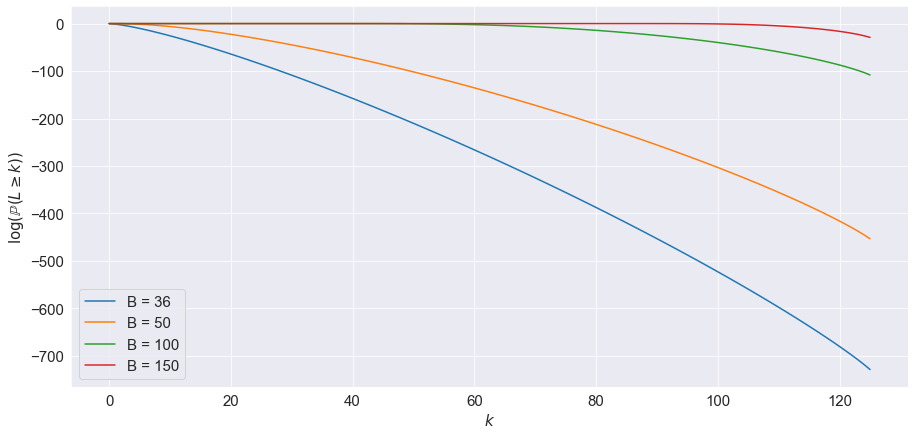

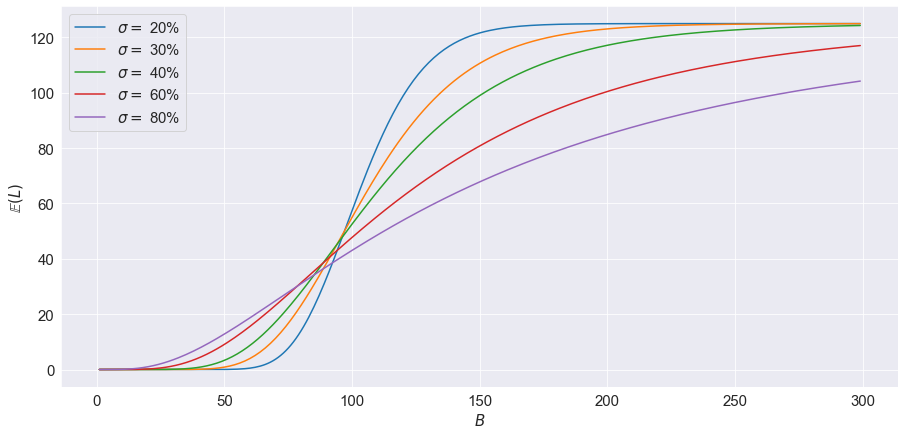

In [1089]:
N = 125  # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e4)

plt.figure(figsize=(15,7))
espace = np.arange(-0.1,N)

# Influence sur la Distribution de probabitilié de la v.a.r 'L' ----------------------------------

for b in [36,50,100,150]:
    mean = (1/sigma)*(np.log(b/S0)-0.5*sigma*sigma)
    p = sps.norm.cdf(mean)
    fBin = sps.binom.sf(espace,N,p)
    plt.plot(espace+0.1,np.log(fBin),label="B = "+str(b))
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

# Espérance de L en fonction de B ---------------------------------------------------------------

plt.figure(figsize=(15,7))
space = np.arange(1,300)
sigmaS = [0.2,0.3,0.4,0.6,0.8]
for sigma in sigmaS : 
    E_L = N*sps.norm.cdf((1/sigma)*np.log(space/(S0*np.exp(0.5*sigma**2))))
    plt.plot(space,E_L,label=r"$\sigma =$ "+str(int(sigma*100))+'%')
plt.xlabel(r'$B$')
plt.ylabel(r'$\mathbb{E}(L)$')
plt.legend()
plt.show()

#### Estimation de la perte associée au défaut à l'instant T :

Tentative de calcul de E[Pt / L >= k] par Monte Carlo



La méthode de MC s'est arrêté à k = 6


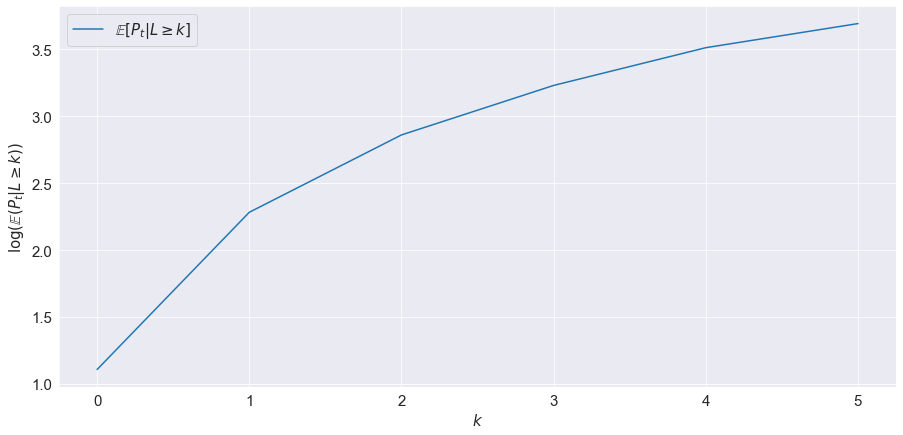

Perte (sachat L >= 0 ) :  3.0255823500487242
Std =  0.03100464648104582
Perte (sachat L >= 1 ) :  9.80358482939772
Std =  0.03100464648104582
Perte (sachat L >= 2 ) :  17.481691553982305
Std =  0.024702886901733587
Perte (sachat L >= 3 ) :  25.31255824312136
Std =  0.012599918566992108
Perte (sachat L >= 4 ) :  33.56644834279225
Std =  0.00461918371910171
Perte (sachat L >= 5 ) :  40.195888943890125
Std =  0.0015772656224696513


In [1090]:
N = 125  # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e5)
B = 36
mean = (1/sigma)*np.log(B*np.exp(-0.5*sigma*sigma)/S0)
q = sps.norm.ppf(0.975)

plt.figure(figsize=(15,7))

std_mc = []
mean = (1/sigma)*(np.log(B/S0)-0.5*sigma*sigma)
p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)
fBin = sps.binom.sf(espace,N,p)
mean0 = 0
E_Pt_MC = []
print("Tentative de calcul de E[Pt / L >= k] par Monte Carlo")
W = np.random.normal(mean0,1,size=(M,N))
L = np.sum(W <= mean,axis = 1)
S = 0.3*S0*np.exp(-0.5*(sigma**2)+sigma*W)*(W <= mean)
pbar = tqdm(total=N)
for k in range(N+1):
    res = np.sum(S,axis=1)*(L >= k)
    mu = np.mean(res)
    E_Pt_MC.append(mu/np.mean(L >= k))
    si = np.std(res)*q*(1/np.sqrt(M))
    std_mc.append(si)
    pbar.update(1)
pbar.close()

Stop_MC_2 = 0
while  Stop_MC_2 < N and std_mc[Stop_MC_2] != 0 :
    Stop_MC_2+=1

# Calcul du premier k non calculé par MC 

print("La méthode de MC s'est arrêté à k = "+str(Stop_MC_2))

log = True
plt.xlabel(r'$k$')
if log:
    plt.plot(range(N+1),np.log(E_Pt_MC),label=r'$\mathbb{E}\left[P_t | L \geq k\right]$')
    plt.ylabel(r'$\log(\mathbb{E}(P_t | L \geq k))$')
else :
    plt.plot(range(N+1),E_Pt_MC,label="E[Pt / L >= k]")
    plt.ylabel(r'$\mathbb{E}(P_t | L \geq k)$')
plt.legend()
plt.show()

for i in range(Stop_MC_2):
    print('Perte (sachat L >=',i,') : ',E_Pt_MC[i])
    print('Std = ',std_mc[i])

On essaie à développer l'expression de notre perte pour nous ramener à des quantité plus facile à estimer.<br><br>
On a que :
$$
f(k) = \mathbb{E}\left(P_t | L \geq k\right)
     = \mathbb{E}\left(\sum_{i=1}^N S_T^i \mathbb{1}_{\{S_T^i \leq B\}} | L \geq k\right)\\
     = \sum_{i=1}^N \mathbb{E}\left(S_T^i \mathbb{1}_{\{S_T^i \leq B\}} | L \geq k\right)\\
     = \sum_{i=1}^N \mathbb{E}\left(S_T^1 \mathbb{1}_{\{S_T^1 \leq B\}} | L \geq k\right)\\
     = N \mathbb{P}\left(S_T^1 \leq B | L \geq k \right)\mathbb{E}\left(S_T^i  | S_T^1 \leq B \cap L \geq k\right)\\
     = N \mathbb{P}\left(S_T^1 \leq B | L \geq k \right)\mathbb{E}\left(S_T^i  | S_T^1 \leq B \cap L \geq k \right)
$$ <br>
et donc $\forall$  $1 \leq k \leq N$:
$$
     f(k) = N \mathbb{P}\left(S_T^1 \leq B | L \geq k \right)\mathbb{E}\left(S_T^i  | S_T^1 \leq B\right)
$$<br>
Il nous faut donc pour cela estimer les quantités $\mathbb{P}\left(S_T^1 \leq B | L \geq k \right)$ et $\mathbb{E}\left(S_T^i  | S_T^1 \leq B\right)$.<br> La première étant équivalente à la probabilité $\mathbb{P}\left(X_1 = 1 | \sum_{i=1}^N X_i \geq k \right)$ avec les $X_i$ des variables aléatoires de bernoulli de paramètre $p = \mathbb{P}(W < W_0)$ définie plus haut.<br>
Et la deuxième quantité n'est autre que la moyenne de l'actif à la queue de la distribution.

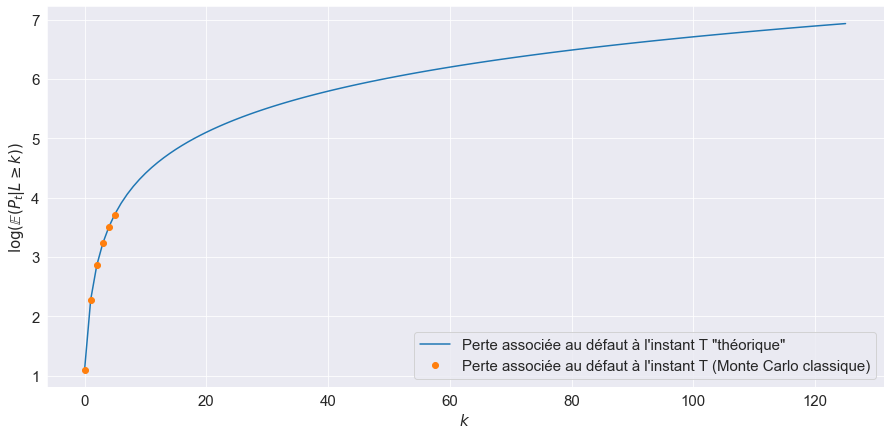

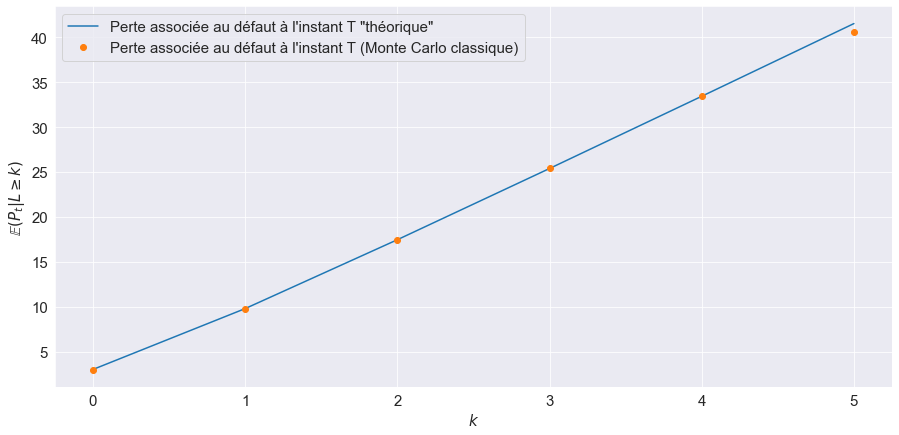

In [1074]:
N = 125
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
B = 36
M = int(1e5)

mean = (1/sigma)*np.log(B*np.exp(-0.5*sigma*sigma)/S0)

# Calcul de la première quantité P(X_1 = 1 / \sum X_i >= k) --------------------------------------------------
p = sps.norm.cdf(mean)

espace = np.arange(-0.1,N)
espace2 = np.arange(-0.1,N-1)
fBin = sps.binom.sf(espace,N,p)
fBin2 = sps.binom.sf(espace2,N-1,p)

def P1(i):
    if i == 0:
        return 1
    return (fBin2[i-1])/fBin[i]

res = np.array([P1(i) for i in range(0,N+1)])

# L'estimation de l'espérance à la queue revient a estimer P(W < W_0 - sigma)---------------------------------

mean2 = (1/sigma)*np.log(B*np.exp(-0.5*sigma*sigma)/S0)-sigma

Y = np.random.normal(mean2,1,size=M)
p2_es = np.mean(np.exp((mean2)**2/2 - mean2*Y)*(Y<mean2))

p2 = p = sps.norm.cdf(mean2)

E_Pt = 0.3*N*S0*p2*res
E_Pt_es = 0.3*N*S0*p2_es*res

# Affichage de la fonction perte f(k) -------------------------------------------------------------------------

E_Pt_MC = np.array(E_Pt_MC)

log = True
plt.figure(figsize=(15,7))
plt.plot(range(N+1),log*np.log(E_Pt)+E_Pt*(1-log),label="Perte associée au défaut à l'instant T \"théorique\"")
plt.plot(range(N+1),log*np.log(E_Pt_MC)+E_Pt_MC*(1-log),'o',label="Perte associée au défaut à l'instant T (Monte Carlo classique)")
#plt.plot(range(N+1),log*np.log(E_Pt_es)+E_Pt_es*(1-log),'v',label="Perte associée au défaut à l'instant T (estimation de P(W<W_0 - sigma))")
plt.xlabel(r'$k$')
if log:
    plt.ylabel(r'$\log(\mathbb{E}(P_t | L \geq k))$')
else :
    plt.ylabel(r'$\mathbb{E}(P_t | L \geq k)$')
plt.legend()
plt.show()

# Comparaison avec MC ---------------------------------------------------------------------------------------

log = False
plt.figure(figsize=(15,7))
plt.plot(range(Stop_MC_2),log*np.log(E_Pt[:Stop_MC_2])+E_Pt[:Stop_MC_2]*(1-log),label="Perte associée au défaut à l'instant T \"théorique\"")
plt.plot(range(Stop_MC_2),log*np.log(E_Pt_MC[:Stop_MC_2])+E_Pt_MC[:Stop_MC_2]*(1-log),'o',label="Perte associée au défaut à l'instant T (Monte Carlo classique)")
#plt.plot(range(Stop_MC_2),log*np.log(E_Pt_es[:Stop_MC_2])+E_Pt_es[:Stop_MC_2]*(1-log),'v',label="Perte associée au défaut à l'instant T (estimation de P(W<W_0 - sigma))")
plt.xlabel(r'$k$')
if log:
    plt.ylabel(r'$\log(\mathbb{E}(P_t | L \geq k))$')
else :
    plt.ylabel(r'$\mathbb{E}(P_t | L \geq k)$')
plt.legend()
plt.show()



In [288]:
for k in range(Stop_MC_2):
    print("Valeur de la perte : ",E_Pt[k])
    print("Valeur estimé par MC : ",E_Pt_MC[k])
    print("Intervalle de confiance à 95% pour la méthode de MC : I = [",E_B[k],',',E_H[k],']\n')

Valeur de la perte :  2.2068272320369373
Valeur estimé par MC :  2.1992381848797873
Intervalle de confiance à 95% pour la méthode de MC : I = [ 1.8361329505524842 , 2.5623434192070906 ]

Valeur de la perte :  10.611052964774093
Valeur estimé par MC :  10.510760778976014
Intervalle de confiance à 95% pour la méthode de MC : I = [ 10.148971752918326 , 10.872549805033701 ]

Valeur de la perte :  19.7225283513153
Valeur estimé par MC :  19.778548139940312
Intervalle de confiance à 95% pour la méthode de MC : I = [ 19.543764785858418 , 20.013331494022207 ]

Valeur de la perte :  29.030504073846966
Valeur estimé par MC :  30.423950706860357
Intervalle de confiance à 95% pour la méthode de MC : I = [ 30.33072001254724 , 30.517181401173474 ]

Valeur de la perte :  38.418978217088146
Valeur estimé par MC :  47.455404253159514
Intervalle de confiance à 95% pour la méthode de MC : I = [ 47.4252013892504 , 47.48560711706863 ]

Valeur de la perte :  47.847912915851225
Valeur estimé par MC :  151.24

### Cas de sociétés avec volatilités différentes :

#### Distribution de L :

On se place maintenant dans le cas de débiteurs de volatilités différentes. On divise les débiteurs en 5 groupes avec pour chaque groupe un paramètre $\sigma$ diffénrent parmis les valeurs suivantes $\{$ $0.2$ , $0.25$ , $0.3$ , $0.35$ , $0.5$ $\}$. <br>
Dans ce cas la variable aléatoire $L$ et la somme de 5 v.a.r de loi binomiale de paramètre $(N,p_i)$ avec $p_i = \mathbb{P}\left(W \leq W_0\right)$ avec $W_0 = \frac{1}{\sigma_i}\log(B) - \frac{\sigma_i}{2}\log(S_0)$ et donc différent pour chaque groupe d'entreprise.<br>
On calcul alors la distribution demandée à l'aide d'un produit de convolution.

In [1075]:
def produitConvolution(loi1,loi2):
    espace = [i for i in range(len(loi1)+len(loi2)-1)]
    loi3 = [0 for e in espace]
    for k in espace:
        proba = 0
        for i in range(len(loi1)):
            if (k-i)>= 0 and (k-i)<len(loi2):
                loi3[k] += loi1[i]*loi2[k-i]
    return loi3

In [1076]:
N2 = N//5
def distributions(B):
    sigma = np.array([0.2,0.25,0.3,0.35,0.5])
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    P = sps.norm.cdf(mean)
    espace = np.arange(-0.1,N2)
    fBin = sps.binom.sf(espace,N2,P[0])
    for i in range(1,5):
        fBin = produitConvolution(fBin,sps.binom.sf(espace,N2,P[i]))
    return fBin

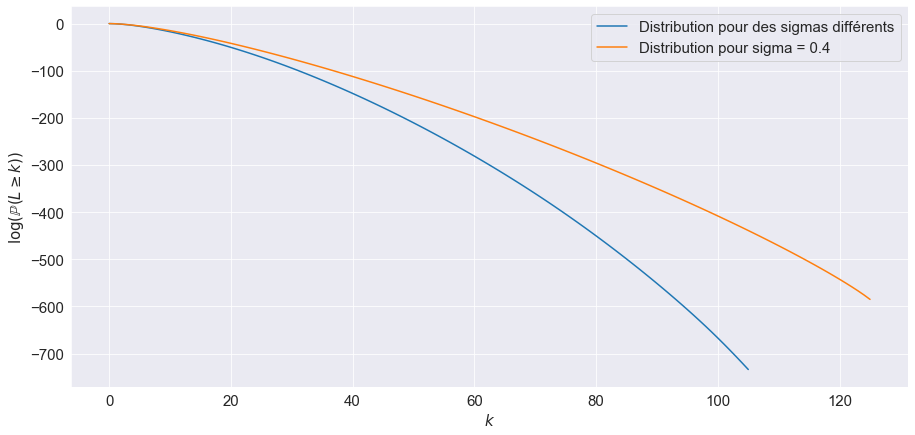

In [1077]:
N = 125
B = 36
sigma = 0.4
M = int(1e5)
B = 36
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)

# Valeurs théoriques des probabilités -------------------------------------------------------

p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)
fBin = sps.binom.sf(espace,N,p)
espace = espace + 0.1


result = distributions(B)

# Les valeurs des probabilités sont beaucoup trop petites pour être seulement considéré par la machine

plt.figure(figsize=(15,7))
plt.plot(range(N+1),np.log(result),label="Distribution pour des sigmas différents")
plt.plot(range(N+1),np.log(fBin),label="Distribution pour sigma = 0.4")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

#### Influence de B et $\sigma$ sur le distribution de L :

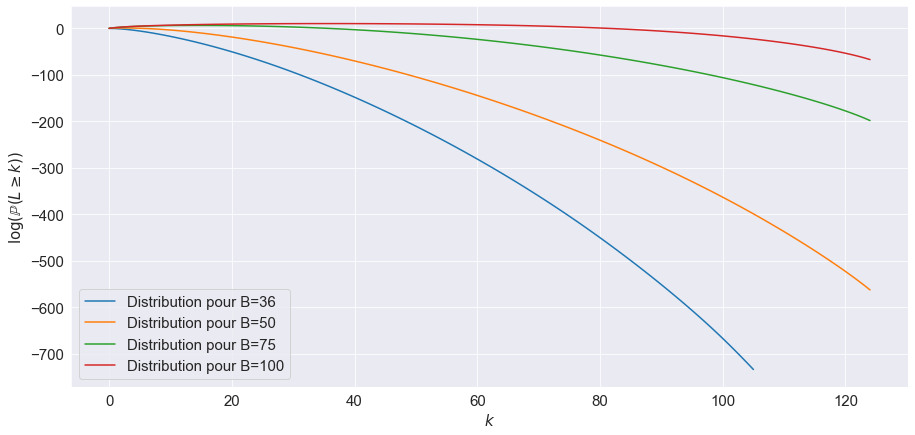

In [1078]:
N = 125
Bs = [36,50,75,100]
plt.figure(figsize=(15,7))
for B in Bs:
    result = distributions(B)
    # Les valeurs des probabilités sont beaucoup trop petites pour être seulement considéré par la machine
    K = 0
    while K < N and result[K] != 0:
        K+=1
    plt.plot(range(K),np.log(result[:K]),label="Distribution pour B="+str(B))
    
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

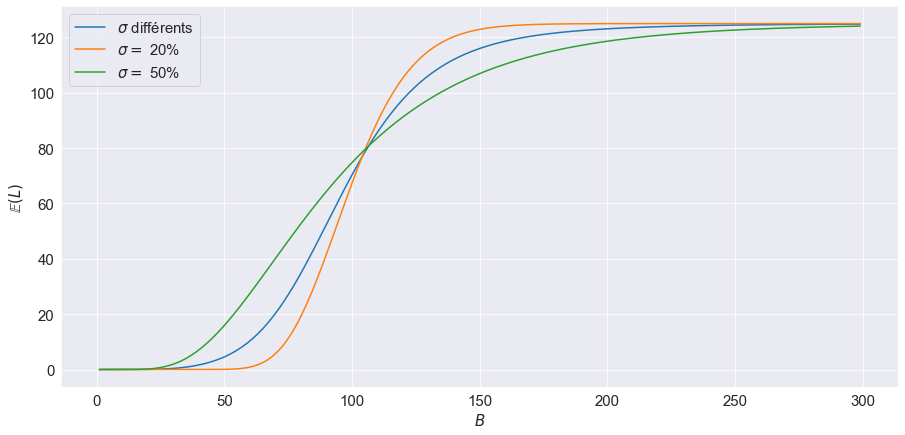

In [1079]:
N= 125

plt.figure(figsize=(15,7))
space = np.arange(1,300)
E_L = np.array([0.0 for i in space])
sigmaS = [0.2,0.25,0.3,0.35,0.5]
for sigma in sigmaS : 
    E_L += (N/5)*sps.norm.cdf((1/sigma)*np.log(space/(S0*np.exp(-0.5*sigma**2))))
plt.plot(space,E_L,label=r"$\sigma$ différents ")

sigmaS = [0.2,0.5]
for sigma in sigmaS : 
    E_L = N*sps.norm.cdf((1/sigma)*np.log(space/(S0*np.exp(-0.5*sigma**2))))
    plt.plot(space,E_L,label=r"$\sigma =$ "+str(int(sigma*100))+'%')

plt.xlabel(r'$B$')
plt.ylabel(r'$\mathbb{E}(L)$')
plt.legend()
plt.show()

#### Estimation de la perte associée au défaut à l'instant T :

In [1080]:
 N2 = N//5
def distributions2(B,j):
    sigma = np.array([0.2,0.25,0.3,0.35,0.5])
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    P = sps.norm.cdf(mean)
    espace = np.arange(-0.1,N2 -1)
    fBin = sps.binom.sf(espace,N2 -1 ,P[j])
    espace = np.arange(-0.1,N2)
    i = (j+1)%5
    while i != j:
        fBin = produitConvolution(fBin,sps.binom.sf(espace,N2,P[i]))
        i = (i+1)%5
    return fBin

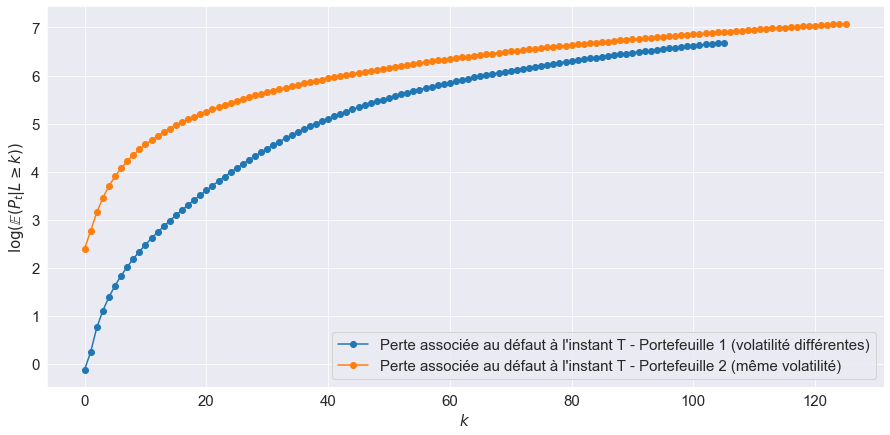

In [1084]:
N = 125
S0 = 100   # Valeur initiale des entreprises 
B = 36
M = int(1e5)

sigma = np.array([0.2,0.25,0.3,0.35,0.5])
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)

# Calcul de la première quantité P(X_1 = 1 / \sum X_i >= k) --------------------------------------------------
mean2 = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)-sigma

P = np.array([0.0 for j in range(N+1)])
for j in range(0,4):
    P += np.append([1.0],distributions2(B,j))*sps.norm.cdf(mean2[j])

fBin = distributions(B)

E_Pt = 0.3*(N/5)*S0*P/fBin

# -----------------------------------------------------------------------------------------
sigma = 0.4
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)

p = sps.norm.cdf(mean)

espace = np.arange(-0.1,N)
espace2 = np.arange(-0.1,N-1)
fBin = sps.binom.sf(espace,N,p)
fBin2 = sps.binom.sf(espace2,N-1,p)

def P1(i):
    if i == 0:
        return 1
    return (fBin2[i-1])/fBin[i]

res = np.array([P1(i) for i in range(0,N+1)])

mean2 = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0) - sigma
p = sps.norm.cdf(mean2)

E_Pt_MmS = 0.3*N*S0*p*res

# -----------------------------------------------------------------------------------------

log = True
plt.figure(figsize=(15,7))
plt.plot(range(N+1),log*np.log(E_Pt)+E_Pt*(1-log),'o-',label="Perte associée au défaut à l'instant T - Portefeuille 1 (volatilité différentes)")
plt.plot(range(N+1),log*np.log(E_Pt_MmS)+E_Pt_MmS*(1-log),'o-',label="Perte associée au défaut à l'instant T - Portefeuille 2 (même volatilité)")
#plt.plot(range(N+1),log*np.log(E_Pt_es)+E_Pt_es*(1-log),'v',label="Perte associée au défaut à l'instant T (estimation de P(W<W_0 - sigma))")
plt.xlabel(r'$k$')
if log:
    plt.ylabel(r'$\log(\mathbb{E}(P_t | L \geq k))$')
else :
    plt.ylabel(r'$\mathbb{E}(P_t | L \geq k)$')
plt.legend()
plt.show()

### Partie II : Cas de débiteurs dépendants

#### Distribution de L :

Méthode naïve MC



Première méthode d'Importance Sampling


(10000, 125)



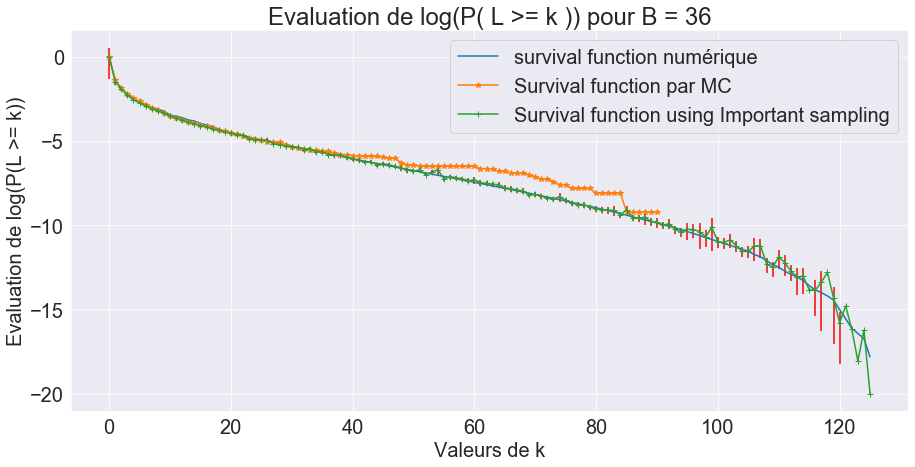

In [846]:
rho = 0.5
N = 125
sigma = 0.4
B = 36

import scipy
from scipy.stats import mvn

mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0) 

Mat_cov = (1-rho)*np.identity(N) +rho*np.ones((N,N)) #Matrice de covariance

Mat_cov_inv = np.linalg.inv(Mat_cov) #Inverse de matrice de covariance

W= np.random.multivariate_normal(np.zeros(N),Mat_cov, size=M)

S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])  #Valeurs des entreprises


W0 = np.array([mean]*N)  #Vecteur des moyennes


espace = np.arange(-0.1,N)


#Calcul numérique des probas P(L >=k)

def Probas(N,r):  # r = rho
    probas=[]
    A = -np.identity(N)
    Mat_cov = (1-r)*np.identity(N) +r*np.ones((N,N))
    vect = -mean*np.ones(N)
    probas.append(mvn.mvnun([-1000]*N,vect,np.zeros(N),A@Mat_cov@A)[0])
    for k in range(1,N+1):
        
        A[k-1][k-1] = 1
        vect[k-1] *= -1
        probas.append(mvn.mvnun([-1000]*N,vect,np.zeros(N),A@Mat_cov@A)[0]*scipy.special.binom(N,k))
        
    return probas

probas_ponctuel = Probas(N,rho)  # P (L=k)
probas_ponctuel=np.array(probas_ponctuel)

probas = [np.sum(probas_ponctuel[k:]) for k in range(len(probas_ponctuel))]  # P(L>=k)


# Méthode naïve MC  -------------------------------------------------------------------------

P = []
W = np.random.multivariate_normal(np.zeros(N),Mat_cov,size=M)
S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])

L = np.sum(S <= B,axis = 1)

print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling-----------------------------------------------------

P_IS = []
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = []
PD = []

mean0= np.array([mean]*N)
meann = np.array([mean0 for i in range(M)])
print(meann.shape)
for k in range(N+1):
    q = min(int(np.ceil(k*np.log(k+1))),N)  # à commenter si besoin
    #q = N  # à commenter si besoin
    mean0 -= -0.01*np.array([ i< q for i in range(N)]) # à commenter si besoin
    #W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,size=(M,N-q)),axis=1)
    W= np.random.multivariate_normal(mean0,Mat_cov, size=M)
    L = np.sum(W <= mean,axis = 1)
    res = (L >= k)*np.array([np.exp(0.5*(mean0@Mat_cov_inv@(mean0-W[i]) - W[i]@Mat_cov_inv@mean0)) for i in range(M)])
    mu = np.mean(res)
    P_IS.append(mu)
    si = np.std(res)*1.96*(1/np.sqrt(M))
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()

# Préparation des np.arrays -----------------------------------------------------------------

plt.figure(figsize=(15,7))
   
P = np.array(P)
P_IS = np.array(P_IS)
probas = np.array(probas)
PH = np.array(PH)
PD = np.array(PD)


# Affichage des courbes ---------------------------------------------------------------------

plt.plot(range(N+1),np.log(probas),label='survival function numérique')
plt.plot(range(N+1),np.log(P),label="Survival function par MC",marker='*',markersize=6)
plt.plot(range(N+1),np.log(P_IS),label="Survival function using Important sampling",marker='+',markersize=6)
'''Affichage des intervalles de confiance 95%  pour la méthode IS'''
for i in range(N):
    plt.vlines(i,ymin=np.log(PD[i]),ymax=np.log(PH[i]),color='r', linestyles='solid')
plt.title("Evaluation de log(P( L >= k )) pour B = 36")
plt.xlabel("Valeurs de k")
plt.ylabel("Evaluation de log(P(L >= k))")
plt.legend()
plt.show()


In [297]:
Examples = [0,2,5,10,25,40,60,100,125] 

for i in Examples:
    if i<=N:
        print("Pour k = ",i)
        print("Valeur estimée par MC : P(L>=",i,") = ",P[i])
        print("Valeur estimée par IS : P(L>=",i,") = ",P_IS[i])
        print("Valeur numérique calculée : P(L>=",i,") = ",probas[i],'\n')

Pour k =  0
Valeur estimée par MC : P(L>= 0 ) =  1.0
Valeur estimée par IS : P(L>= 0 ) =  0.945140449238442
Valeur numérique calculée : P(L>= 0 ) =  1.0156674318412076 

Pour k =  2
Valeur estimée par MC : P(L>= 2 ) =  0.0468
Valeur estimée par IS : P(L>= 2 ) =  0.047442176916325254
Valeur numérique calculée : P(L>= 2 ) =  0.04846169844182033 

Pour k =  5
Valeur estimée par MC : P(L>= 5 ) =  0.01006
Valeur estimée par IS : P(L>= 5 ) =  0.009943938062445364
Valeur numérique calculée : P(L>= 5 ) =  0.010706674992894075 

Pour k =  10
Valeur estimée par MC : P(L>= 10 ) =  0.00198
Valeur estimée par IS : P(L>= 10 ) =  0.001679515116167863
Valeur numérique calculée : P(L>= 10 ) =  0.0016153474531342509 

Pour k =  25
Valeur estimée par MC : P(L>= 25 ) =  0.0
Valeur estimée par IS : P(L>= 25 ) =  6.148177652493959e-07
Valeur numérique calculée : P(L>= 25 ) =  6.666470541827149e-07 



**Utilisation d'importance sampling**

Méthode naïve MC



Première méthode d'Importance Sampling


(100000, 20)



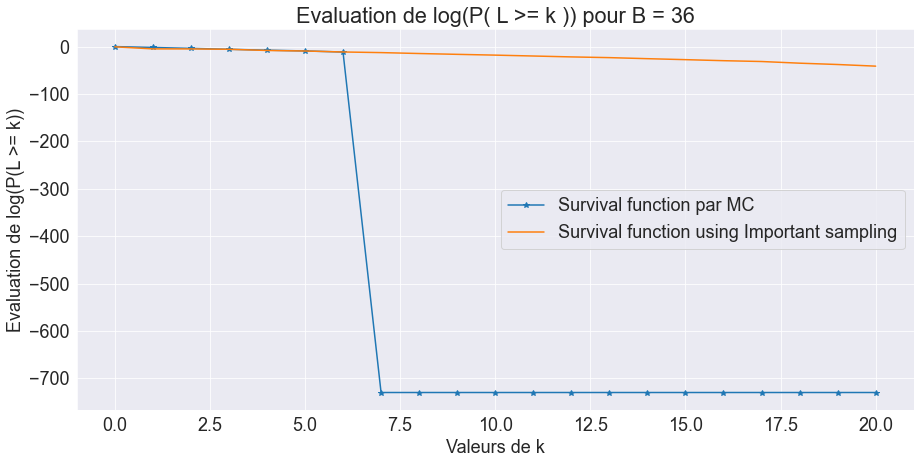

In [11]:
rho = 0.1
N=20

Mat_cov = (1-rho)*np.identity(N) +rho*np.ones((N,N)) #Matrice de covariance

Mat_cov_inv = np.linalg.inv(Mat_cov) #Inverse de matrice de covariance

W= np.random.multivariate_normal(np.zeros(N),Mat_cov, size=M)

S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])  #Valeurs des entreprises


W0 = np.array([mean]*N)  #Vecteur des moyennes


espace = np.arange(-0.1,N)


                
                


# Méthode naïve MC  -------------------------------------------------------------------------

P = []
W = np.random.multivariate_normal(np.zeros(N),Mat_cov,size=M)
S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])

L = np.sum(S <= B,axis = 1)

print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling-----------------------------------------------------

P_IS = []
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = []
PD = []

mean0= np.array([mean]*N)
meann = np.array([mean0 for i in range(M)])
print(meann.shape)
for k in range(N+1):
    q = N
    mean0 = mean0 -0.01
    #W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,size=(M,N-q)),axis=1)
    W= np.random.multivariate_normal(mean0,Mat_cov, size=M)
    L = np.sum(W <= mean,axis = 1)
    res = (L >= k)*np.array([np.exp(0.5*(mean0@Mat_cov_inv@(mean0-W[i]) - W[i]@Mat_cov_inv@mean0)) for i in range(M)])
    mu = np.mean(res)
    P_IS.append(mu)
    si = np.std(res)*1.96*(1/np.sqrt(M))
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()

# Préparation des np.arrays -----------------------------------------------------------------

plt.figure(figsize=(15,7))
for i in range(len(P)):
    P[i] = (P[i]==0.0)*(np.exp(-730)) + (P[i]!=0.0)*P[i]
    P_IS[i] = (P_IS[i]==0.0)*(np.exp(-730)) + (P_IS[i]!=0.0)*P_IS[i]

P = np.array(P)
P_IS = np.array(P_IS)
#probas = np.array(probas)
PH = np.array(PH)
PD = np.array(PD)

# Affichage des courbes ---------------------------------------------------------------------

plt.plot(range(N+1),np.log(P),label="Survival function par MC",marker='*',markersize=6)
plt.plot(range(N+1),np.log(P_IS),label="Survival function using Important sampling")

plt.title("Evaluation de log(P( L >= k )) pour B = 36")
plt.xlabel("Valeurs de k")
plt.ylabel("Evaluation de log(P(L >= k))")
plt.legend()
plt.show()



Pour rho =  0.1



Pour rho =  0.4



Pour rho =  0.7



Pour rho =  0.99


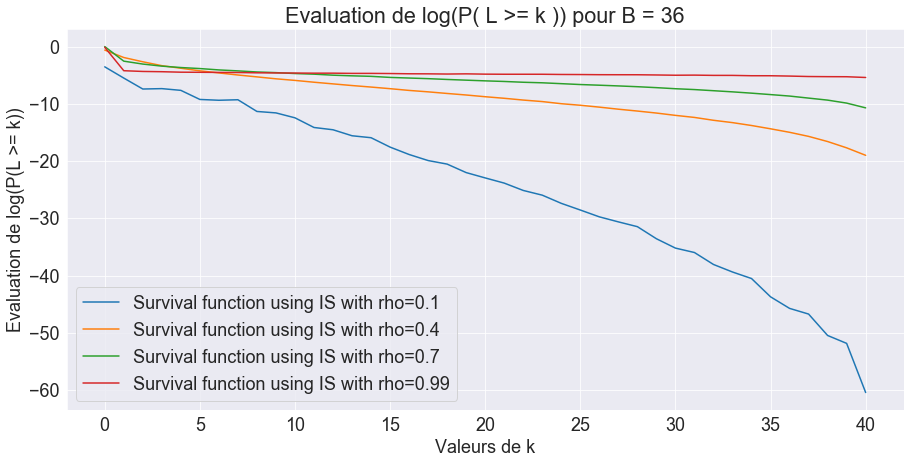

In [26]:
Rhos = [0.1, 0.4, 0.7,0.99]
N=40
plt.figure(figsize=(15,7))
Probas = []
for rho in Rhos:
    Mat_cov = (1-rho)*np.identity(N) +rho*np.ones((N,N)) 

    Mat_cov_inv = np.linalg.inv(Mat_cov)

    W= np.random.multivariate_normal(np.zeros(N),Mat_cov, size=M)

    S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])

    W0 = np.array([mean]*N)
    
    espace = np.arange(-0.1,N)
    

    
   
  

    # Première méthode d'Importance Sampling-----------------------------------------------------

    P_IS = []
    print("Pour rho = ",rho)
    pbar = tqdm(total=N)
    PH = []
    PD = []

    mean0= np.array([mean]*N)
    meann = np.array([mean0 for i in range(M)])
    for k in range(N+1):
        q = N
        mean0 = mean0 -0.01
        #W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,size=(M,N-q)),axis=1)
        W= np.random.multivariate_normal(mean0,Mat_cov, size=M)
        L = np.sum(W <= mean,axis = 1)
        res = (L >= k)*np.array([np.exp(0.5*(mean0@Mat_cov_inv@(mean0-W[i]) - W[i]@Mat_cov_inv@mean0)) for i in range(M)])
        mu = np.mean(res)
        P_IS.append(mu)
        si = np.std(res)*1.96*(1/np.sqrt(M))
        PH.append(mu+si)
        PD.append(mu-si)
        pbar.update(1)
    pbar.close()

    # Préparation des np.arrays -----------------------------------------------------------------

    
    for i in range(len(P_IS)):
        P_IS[i] = (P_IS[i]==0.0)*(np.exp(-730)) + (P_IS[i]!=0.0)*P_IS[i]

    P_IS = np.array(P_IS)
    #probas = np.array(probas)
    PH = np.array(PH)
    PD = np.array(PD)

    # Affichage des courbes ---------------------------------------------------------------------

    plt.plot(range(N+1),np.log(P_IS),label="Survival function using IS with rho="+str(rho))
    
    Probas.append(P_IS.copy())
    
    

plt.title("Evaluation de log(P( L >= k )) pour B = 36")
plt.xlabel("Valeurs de k")
plt.ylabel("Evaluation de log(P(L >= k))")
plt.legend()
plt.show()

On voit que pour les différents courbes font intersections et changent de comportement aux alentours de $k=20$ qui est la moitié de $N=40$, ceci est en accord avec nos attentes puisque s'il y a plus que la moitié qui font faillite ils ont plus de pouvoir de tirer d'autres entreprises à tomber en défaut et du coup la probabilité devient plus grande, et on voit le même phénomène si plus que la moitié ne tombent pas en défaut, c'est à dire qu'elles tirent les autres entreprisent pour qu'elles ne fassent pas de défaut elles non plus.

Pour B =  36



Pour B =  50



Pour B =  70



Pour B =  95


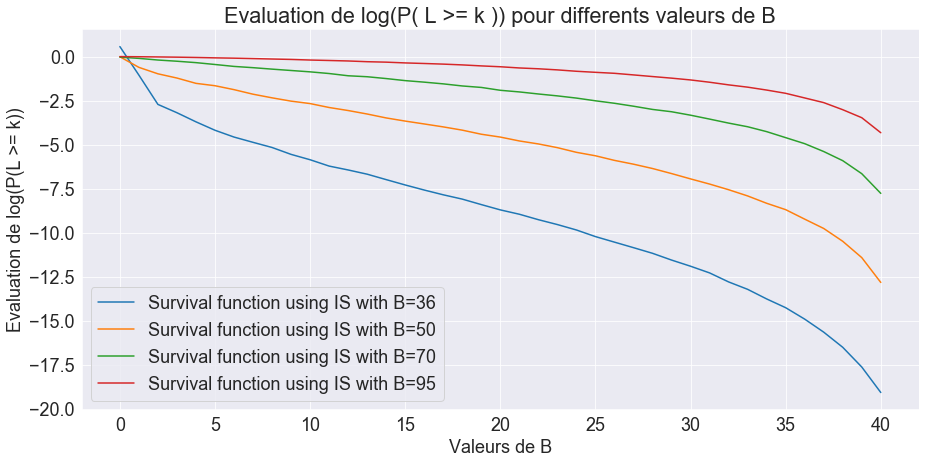

In [23]:
#Influence du seuil B 

rho = 0.4
plt.figure(figsize=(15,7))
Mat_cov = (1-rho)*np.identity(N) +rho*np.ones((N,N)) 

Mat_cov_inv = np.linalg.inv(Mat_cov)

W= np.random.multivariate_normal(np.zeros(N),Mat_cov, size=M)

S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])

W0 = np.array([mean]*N)
    
espace = np.arange(-0.1,N)
    
B_vals = [36, 50 , 70, 95]
    
for B in B_vals:    
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
  

    # Première méthode d'Importance Sampling-----------------------------------------------------

    P_IS = []
    print("Pour B = ",B)
    pbar = tqdm(total=N)
    PH = []
    PD = []

    mean0= np.array([mean]*N)
    meann = np.array([mean0 for i in range(M)])
    for k in range(N+1):
        q = N
        mean0 = mean0 - 0.01
        #W = np.append(np.random.normal(mean0,1,size=(M,q)),np.random.normal(0,size=(M,N-q)),axis=1)
        W= np.random.multivariate_normal(mean0,Mat_cov, size=M)
        L = np.sum(W <= mean,axis = 1)
        res = (L >= k)*np.array([np.exp(0.5*(mean0@Mat_cov_inv@(mean0-W[i]) - W[i]@Mat_cov_inv@mean0)) for i in range(M)])
        mu = np.mean(res)
        P_IS.append(mu)
        si = np.std(res)*1.96*(1/np.sqrt(M))
        PH.append(mu+si)
        PD.append(mu-si)
        pbar.update(1)
    pbar.close()

    # Préparation des np.arrays -----------------------------------------------------------------

    
    for i in range(len(P_IS)):
        P_IS[i] = (P_IS[i]==0.0)*(np.exp(-730)) + (P_IS[i]!=0.0)*P_IS[i]

    P = np.array(P)
    P_IS = np.array(P_IS)
    #probas = np.array(probas)
    PH = np.array(PH)
    PD = np.array(PD)

    # Affichage des courbes ---------------------------------------------------------------------

    plt.plot(range(N+1),np.log(P_IS),label="Survival function using IS with B="+str(B))


plt.title("Evaluation de log(P( L >= k )) pour differents valeurs de B")
plt.xlabel("Valeurs de B")
plt.ylabel("Evaluation de log(P(L >= k))")
plt.legend()
plt.show()

La probabilité $\mathbb{P}(L \geq k) $ est croissante en fonction de $B$. Ceci est logique car plus le seuil $B$ est grand plus une entreprise fait faillite plus facilement.

Tentative de calcul de E[Pt / L >= k] par Importance Sampling


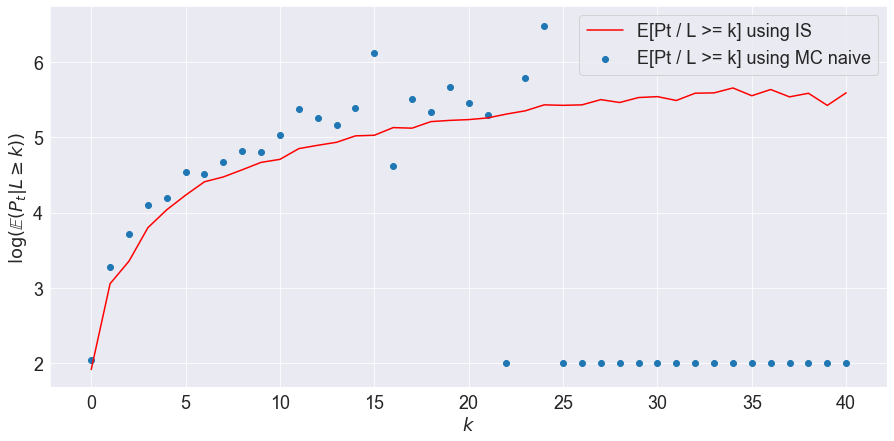

In [27]:
# Esperance de perte
N = 40  # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e4)
B = 36
rho=0.4
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)



Mat_cov = (1-rho)*np.identity(N) +rho*np.ones((N,N)) 

Mat_cov_inv = np.linalg.inv(Mat_cov)

#W= np.random.multivariate_normal(np.zeros(N),Mat_cov, size=M)

S = np.array([S0*np.exp(-0.5*sigma*sigma+sigma*W[i,:]) for i in range(M)])

W0 = np.array([mean]*N)
mean0 = 0
E_Pt_IS = []
E_Pt_MC = []
E_H = []
E_B = []
print("Tentative de calcul de E[Pt / L >= k] par Importance Sampling")
pbar = tqdm(total=N)
for k in range(N+1):
    #q = min(int(np.ceil(k*np.log(k+1))),N)  # à commenter si besoin
    #q = N  # à commenter si besoin
    #mean0 = -1/(1-k/(N+1)) # à commenter si besoin
    W_MC = np.random.multivariate_normal(np.zeros(N),Mat_cov, size=M)
    W = np.random.multivariate_normal(W0,Mat_cov, size=M)
    L = np.sum(W <= mean,axis = 1)
    L_MC = np.sum(W_MC <= mean , axis=1)
    #print(L.shape)
    S = 0.3*S0*np.exp(-0.5*(sigma**2)+sigma*W)*(W <= mean)
    S_MC = 0.3*S0*np.exp(-0.5*(sigma**2)+sigma*W)*(W_MC <= mean)
    #print(S.shape)
    
    res = np.sum(S,axis=1)*(L >= k)*np.array([np.exp(0.5*(W0@Mat_cov_inv@(W0-W[i]) - W[i]@Mat_cov_inv@W0)) for i in range(M)])
    res_MC = np.sum(S_MC,axis=1)*(L_MC >= k)
    mu = np.mean(res)
    mu_MC = np.mean(res_MC)
    E_Pt_IS.append(mu/Probas[1][k])
    E_Pt_MC.append(mu_MC/Probas[1][k])
    '''si = np.std(res)*1.96*(1/np.sqrt(M))
    E_H.append(mu/fBin[k]+si)
    E_B.append(mu/fBin[k]-si)'''
    pbar.update(1)
pbar.close()

for i in range(N+1):
    if E_Pt_IS[i] == 0.0:
        E_Pt_IS[i] = np.exp(2)
    if E_Pt_MC[i] == 0.0:
        E_Pt_MC[i] = np.exp(2)
    
E_Pt_IS = np.array(E_Pt_IS)
E_Pt_MC = np.array(E_Pt_MC)

plt.figure(figsize=(15,7))
log = True

plt.plot(range(N+1),log*np.log(E_Pt_IS)+(1-log)*E_Pt_IS,color='r',label="E[Pt / L >= k] using IS")
plt.scatter(range(N+1),log*np.log(E_Pt_MC)+(1-log)*E_Pt_MC,label="E[Pt / L >= k] using MC naive")
plt.xlabel(r'$k$')
if log:
    plt.ylabel(r'$\log(\mathbb{E}(P_t | L \geq k))$')
else :
    plt.ylabel(r'$\mathbb{E}(P_t | L \geq k)$')
plt.legend()
plt.show()

### Partie III : Nouvelle définition de la faillite d'un débiteur

On commence par le cas où les débiteurs serait tous indépendants. Le problème comme au cas de défaut à maturité se résume à l'estimation de la probabilité de l'évènement : $\{ \text{L'entreprise } i \text{ tombe en défaut}\}$ qui est le même si on choisit un même volatilité $\sigma$ pour toutes les entreprises et un même seuil de défaut $B$.<br>
On remarque que dans notre cas : $\{ \text{L'entreprise } i \text{ tombe en défaut}\} = \bigcup\limits_{k=1}^{k_f}\{S_{t_k}^i\leq B\}$  avec $t_k = k \Delta t = \frac{k}{12}$  et $k_f = 12$ dans le cas où l'on prendrai une date par mois.

#### Distribution de L :


Probabilité de défaut par MC                       p =  0.011724000000000002
Probabilité de défaut par IPS (traj décroissantes) p =  0.01136627102062451
Probabilité de défaut par IPS (traj basses)        p =  0.012292112269388273


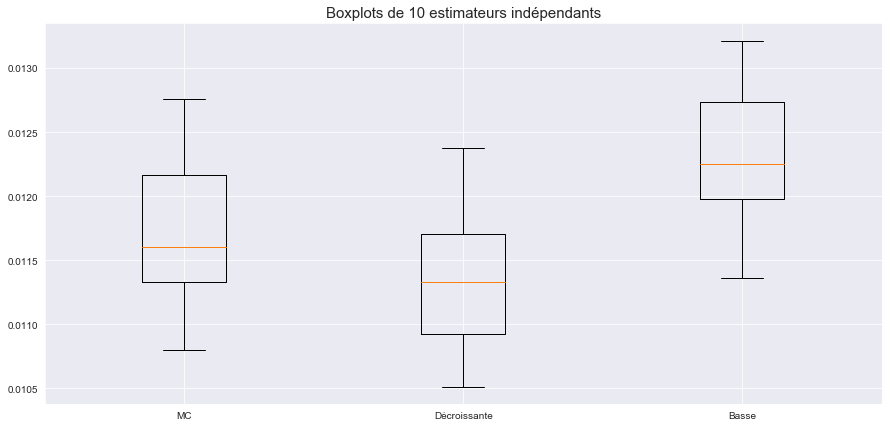

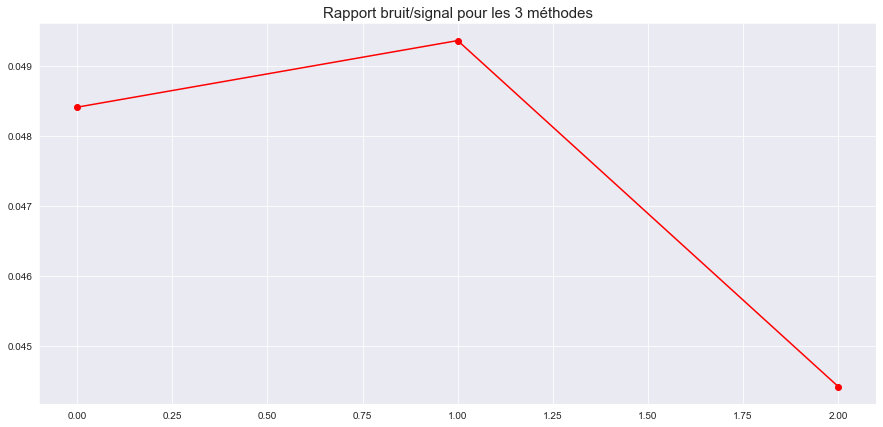

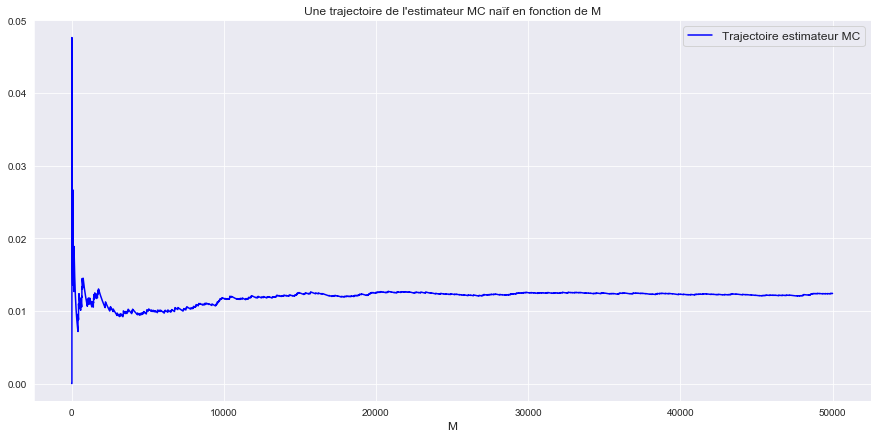

In [847]:
'''
On estime la probabilité qu'une seule entreprise tombe en défaut par IPS
'''

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline


def meanVect(S0,B,sigma,n,M):
    return np.array([[(1/sigma)*(np.log(B/S0)+0.5*sigma*sigma*(t/n)) for t in range(1,n+1)] for i in range(M)])

def estimationIPS_ind(S0,B,sigma,n,M,progress):

    ############################################
    # Boucle sur le nombre de réalisations 
    # indépendantes de l'estimateur, pour M fixé
    ############################################
    NbrIter = 10
    
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    
    a = mean*np.sqrt(n)
    
    # La variable Stock est utilisée pour stocker les tirages des différents
    # estimateurs. Il y a trois colonnes, car nous simulons trois estimateurs :
    # + un Monte-Carlo naïf avec M points, 
    # + l'algo de sélection-mutation avec sélection haute, 
    # + l'algo de sélection-mutation avec sélection croissante.

    Stock = np.zeros((NbrIter, 3))
    if progress : 
        pbar = tqdm(total=NbrIter)
    for nn in range(NbrIter):    
        # Tirages de M x n v.a. N(0,1) qui seront utilisées dans toutes les méthodes
        Y = np.random.randn(M, n)*(1/np.sqrt(n))

        ###############################
        # Methode Monte-Carlo naïve
        ###############################

        # M réalisations de X_n : M tirages de gaussiennes N(0,n) i.i.d.
        G = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)

        estim_MC = np.mean(G > 0)

        # Stockage des NbrIter estimateurs MC naïfs
        Stock[nn, 0] = estim_MC

        ###############################################################################
        ## En pondérant les trajectoires hautes : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = float(a)/(n+1)

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, 1] = Y[:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * ( X[:,p]  - X[:,p-1]) )

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = X[indices, :]

            # Etape de mutation
            X[:, p+1] = X[:, p] + Y[:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        facteur_1 = np.mean( (np.sum(X[:,1:] <= meanVect(S0,B,sigma,n,M),axis=1) > 0) * np.exp(-la * X[:, -1] ) )

        estimateur = facteur_1 * estim_const_normalisation

        # Stockage des NbrIter estimateurs
        Stock[nn, 1] = estimateur
        ###############################################################################
        ## En pondérant les trajectoires basses : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = 2*a/(n*(n-1))

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, 1] = Y[:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * X[:,p])

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = X[indices, :]

            # Etape de mutation
            X[:, p+1] = X[:, p] + Y[:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        facteur_1 = np.mean( (np.sum(X[:,1:] <= meanVect(S0,B,sigma,n,M),axis=1) > 0) * np.exp(-la * np.sum( X[:, :-1], axis=1) ) )

        estimateur = facteur_1 * estim_const_normalisation

        # Stockage des NbrIter estimateurs
        Stock[nn, 2] = estimateur
        if progress : 
            pbar.update(1)
    if progress : 
        pbar.close()
    return Stock
    
#########################
# Paramètres du problème
#########################
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(5E4)
#  définition du seuil
B = 36
sigma = 0.4
S0 = 100

# Calcul des estimations
Stock = estimationIPS_ind(S0,B,sigma,n,M,True)


#######################
## Affichages proposés
#######################
#Affichage des résultas pour chaque estimateur
print("Probabilité de défaut par MC                       p = ",str(np.mean(Stock[:,0])))
print("Probabilité de défaut par IPS (traj décroissantes) p = ",str(np.mean(Stock[:,1])))
print("Probabilité de défaut par IPS (traj basses)        p = ",str(np.mean(Stock[:,2])))
# Comparer les boxplots des échantillons de taille NbrIter obtenus pour les 3 estimateurs
plt.figure(figsize=(15,7))

plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
plt.boxplot(Stock[:, 0:3], positions=[1,2,3],
            labels = ['MC','Décroissante','Basse'])

# Comparer les 3 estimateurs par le ratio "écart-type / valeur moyenne", 
# calculé sur les échantillons de taille NbrIter
plt.show()
plt.figure(figsize=(15,7))

mean_stock = np.mean(Stock, axis=0)

st_dev = np.std(Stock, axis=0)

plt.plot(st_dev/mean_stock,'r-o')
plt.title("Rapport bruit/signal pour les 3 méthodes", fontsize=15)
plt.show()
# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)
plt.figure(figsize=(15,7))
plt.title("Une trajectoire de l'estimateur MC naïf en fonction de M")

#Exemple de trajectoire pour MC
Y = np.random.randn(M, n)*(1/np.sqrt(n))
Z = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)
estim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)

plt.plot(np.arange(1,M+1), estim_mc, color='b', label="Trajectoire estimateur MC")
plt.xlabel('M', fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.show()

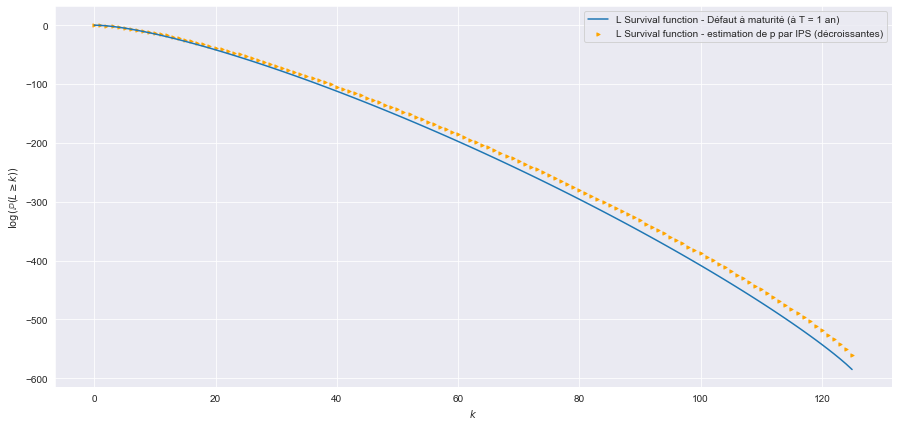

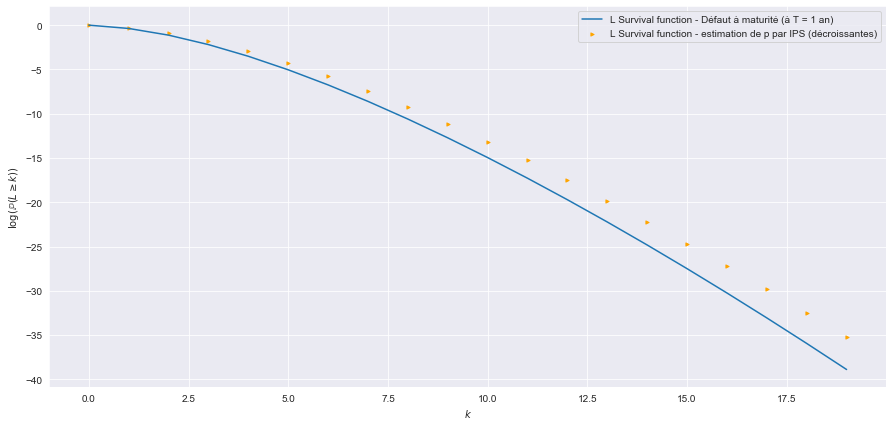

In [848]:
N = 125 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
B = 36
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)

# Valeurs théoriques des probabilités -------------------------------------------------------

p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)

fBin = sps.binom.sf(espace,N,p)
distDecroi = sps.binom.sf(espace,N,np.mean(Stock[:,1]))

espace = espace + 0.1

plt.figure(figsize=(15,7))
plt.plot(espace,np.log(fBin),label="L Survival function - Défaut à maturité (à T = 1 an)")
plt.scatter(espace,np.log(distDecroi),marker = '>', s = 10,color='orange',
            label="L Survival function - estimation de p par IPS (décroissantes)")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(espace[:20],np.log(fBin[:20]),label="L Survival function - Défaut à maturité (à T = 1 an)")
plt.scatter(espace[:20],np.log(distDecroi[:20]),marker = '>', s = 10,color='orange',
            label="L Survival function - estimation de p par IPS (décroissantes)")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

#### Influence de B sur la distribution de L :

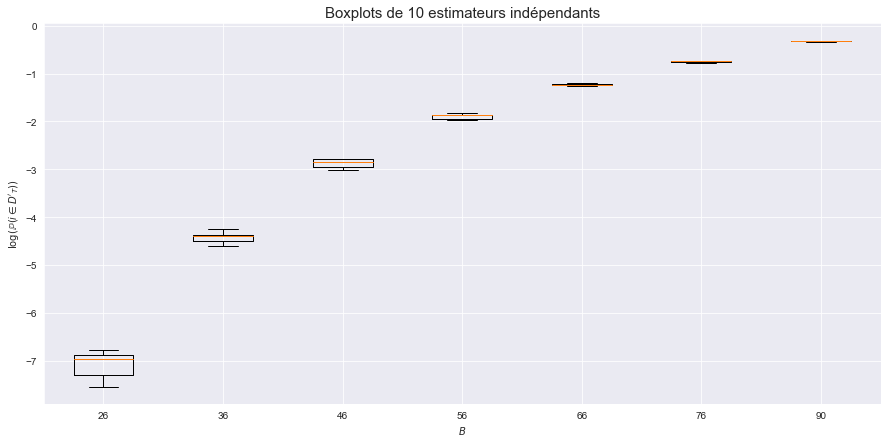

In [384]:
'''
On estime la probabilité de défaut d'une seule entreprise pour différentes valeurs de B
'''
Bs = [26,36,46,56,66,76,90]
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
sigma = 0.4
S0 = 100
Stocks = []
pbar = tqdm(total=len(Bs))
for B in Bs:
    Stocks.append(estimationIPS_ind(S0,B,sigma,n,M,False)[:,2])
    pbar.update(1)
pbar.close()

Stocks = np.log(np.transpose(np.array(Stocks)))

plt.figure(figsize=(15,7))
plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
plt.xlabel(r'$B$')
plt.ylabel(r"$\log(\mathbb{P}(i \in D'_T))$")
plt.boxplot(Stocks[:, 0:len(Bs)], positions=range(1,len(Bs)+1),labels = Bs)
plt.show()

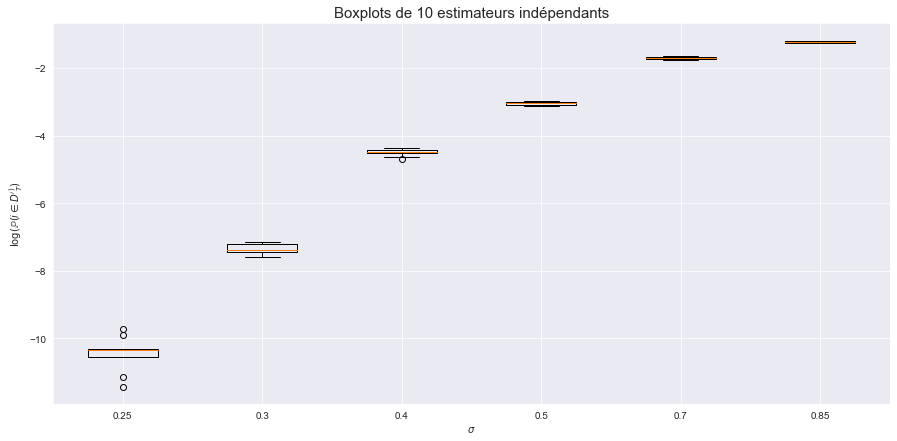

In [347]:
sigmas = [0.25,0.3,0.4,0.5,0.7,0.85]
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
B = 36
S0 = 100

Stocks = []
pbar = tqdm(total=len(sigmas))
for sigma in sigmas:
    Stocks.append(estimationIPS_ind(S0,B,sigma,n,M,False)[:,1])
    pbar.update(1)
pbar.close()

Stocks = np.log(np.transpose(np.array(Stocks)))

plt.figure(figsize=(15,7))
plt.xlabel(r'$\sigma$')
plt.ylabel(r"$\log(\mathbb{P}(i \in D'_T))$")
plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
plt.boxplot(Stocks[:, 0:len(sigmas)], positions=range(1,len(sigmas)+1),labels = sigmas)
plt.show()

#### Estimation de la perte associé au défaut $P_T$ :


Probabilité de défaut par MC                       p =  0.003905998803184648
Probabilité de défaut par IPS (traj décroissantes) p =  0.0039519010127874125
Probabilité de défaut par IPS (traj basses)        p =  0.003866817208329278


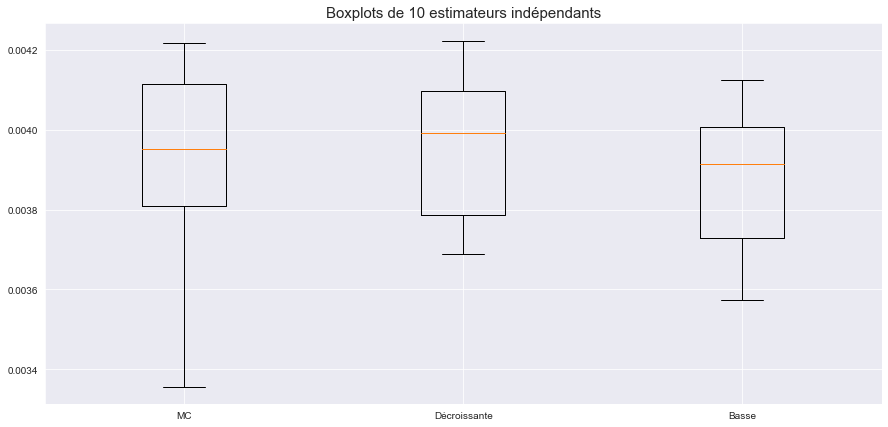

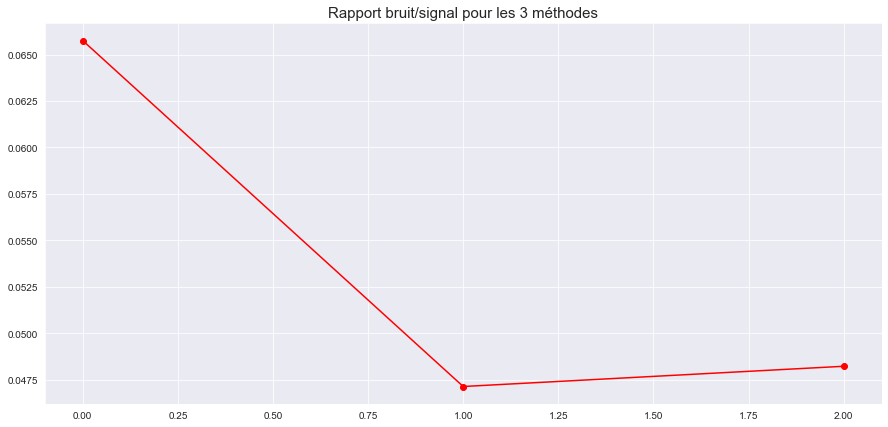

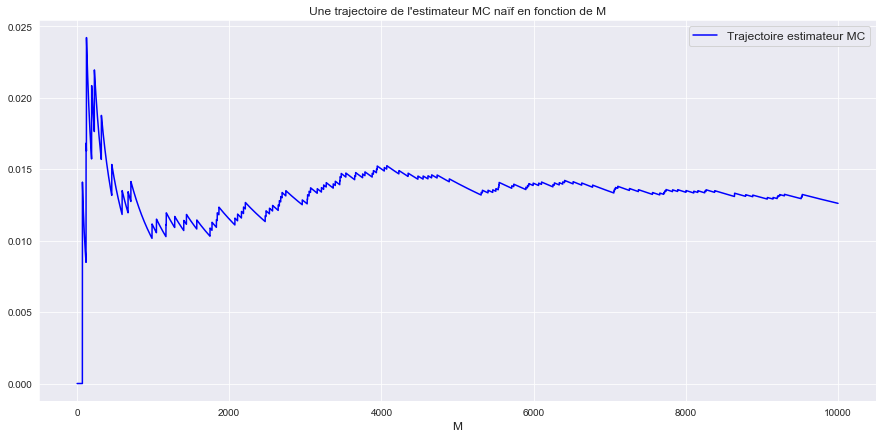

In [381]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline


def meanVect(S0,B,sigma,n,M):
    return np.array([[(1/sigma)*(np.log(B/S0)+0.5*sigma*sigma*(t/n)) for t in range(1,n+1)] for i in range(M)])

def estimationIPS_ind_Loss(S0,B,sigma,n,M,progress):

    ############################################
    # Boucle sur le nombre de réalisations 
    # indépendantes de l'estimateur, pour M fixé
    ############################################
    NbrIter = 10
    
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    
    a = mean*np.sqrt(n)
    
    # La variable Stock est utilisée pour stocker les tirages des différents
    # estimateurs. Il y a trois colonnes, car nous simulons trois estimateurs :
    # + un Monte-Carlo naïf avec M points, 
    # + l'algo de sélection-mutation avec sélection haute, 
    # + l'algo de sélection-mutation avec sélection croissante.

    Stock = np.zeros((NbrIter, 3))
    if progress : 
        pbar = tqdm(total=NbrIter)
    for nn in range(NbrIter):    
        # Tirages de M x n v.a. N(0,1) qui seront utilisées dans toutes les méthodes
        Y = np.random.randn(M, n)*(1/np.sqrt(n))

        ###############################
        # Methode Monte-Carlo naïve
        ###############################

        # M réalisations de X_n : M tirages de gaussiennes N(0,n) i.i.d.
        W = np.cumsum(Y,axis=1)
        G = np.sum(W<= meanVect(S0,B,sigma,n,M), axis=1)
        defaut = np.argwhere(G>0)
        fail = (W <= meanVect(S0,B,sigma,n,M))[G > 0]
        t_i = np.array([np.argwhere(fail[i])[0] for i in range(fail.shape[0])])
        estim_MC = np.sum(np.array([S0*np.exp(0.5*sigma*sigma*(t_i[0,j]+1)*(1/n)+sigma*W[defaut[0,j]][t_i[0,j]]) for j in range(t_i.shape[1])]))/M

        # Stockage des NbrIter estimateurs MC naïfs
        Stock[nn, 0] = estim_MC

        ###############################################################################
        ## En pondérant les trajectoires hautes : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = float(a)/(n+1)

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, 1] = Y[:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * ( X[:,p]  - X[:,p-1]) )

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = X[indices, :]

            # Etape de mutation
            X[:, p+1] = X[:, p] + Y[:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G2 = np.sum(X[:,1:]<= meanVect(S0,B,sigma,n,M), axis=1)
        defaut = np.argwhere(G2>0)
        fail = (X[:,1:] <= meanVect(S0,B,sigma,n,M))[G2 > 0]
        t_i = np.array([np.argwhere(fail[i])[0] for i in range(fail.shape[0])])
        estim_IS = np.sum(np.array([S0*np.exp(0.5*sigma*sigma*(t_i[0,j]+1)*(1/n)+sigma*X[defaut[0,j]][1+t_i[0,j]]) for j in range(t_i.shape[1])]))/M
        facteur_1 = np.mean( (estim_IS) * np.exp(-la * X[:, -1] ) )

        estimateur = facteur_1 * estim_const_normalisation

        # Stockage des NbrIter estimateurs
        Stock[nn, 1] = estimateur
        ###############################################################################
        ## En pondérant les trajectoires basses : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = 2*a/(n*(n-1))

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, 1] = Y[:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * X[:,p])

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = X[indices, :]

            # Etape de mutation
            X[:, p+1] = X[:, p] + Y[:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G2 = np.sum(X[:,1:]<= meanVect(S0,B,sigma,n,M), axis=1)
        defaut = np.argwhere(G2>0)
        fail = (X[:,1:] <= meanVect(S0,B,sigma,n,M))[G2 > 0]
        t_i = np.array([np.argwhere(fail[i])[0] for i in range(fail.shape[0])])
        estim_IS_2 = np.sum(np.array([S0*np.exp(0.5*sigma*sigma*(t_i[0,j]+1)*(1/n)+sigma*X[defaut[0,j]][1+t_i[0,j]]) for j in range(t_i.shape[1])]))/M
        facteur_1 = np.mean( (estim_IS_2) * np.exp(-la * np.sum( X[:, :-1], axis=1) ) )

        estimateur = facteur_1 * estim_const_normalisation

        # Stockage des NbrIter estimateurs
        Stock[nn, 2] = estimateur
        if progress : 
            pbar.update(1)
    if progress : 
        pbar.close()
    return Stock
    
#########################
# Paramètres du problème
#########################
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
B = 36
sigma = 0.4
S0 = 100

# Calcul des estimations
Stock = estimationIPS_ind_Loss(S0,B,sigma,n,M,True)


#######################
## Affichages proposés
#######################
#Affichage des résultas pour chaque estimateur
print("Probabilité de défaut par MC                       p = ",str(np.mean(Stock[:,0])))
print("Probabilité de défaut par IPS (traj décroissantes) p = ",str(np.mean(Stock[:,1])))
print("Probabilité de défaut par IPS (traj basses)        p = ",str(np.mean(Stock[:,2])))
# Comparer les boxplots des échantillons de taille NbrIter obtenus pour les 3 estimateurs
plt.figure(figsize=(15,7))

plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
plt.boxplot(Stock[:, 0:3], positions=[1,2,3],
            labels = ['MC','Décroissante','Basse'])

# Comparer les 3 estimateurs par le ratio "écart-type / valeur moyenne", 
# calculé sur les échantillons de taille NbrIter
plt.show()
plt.figure(figsize=(15,7))

mean_stock = np.mean(Stock, axis=0)

st_dev = np.std(Stock, axis=0)

plt.plot(st_dev/mean_stock,'r-o')
plt.title("Rapport bruit/signal pour les 3 méthodes", fontsize=15)
plt.show()
# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)
plt.figure(figsize=(15,7))
plt.title("Une trajectoire de l'estimateur MC naïf en fonction de M")

#Exemple de trajectoire pour MC
Y = np.random.randn(M, n)*(1/np.sqrt(n))
Z = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)
estim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)

plt.plot(np.arange(1,M+1), estim_mc, color='b', label="Trajectoire estimateur MC")
plt.xlabel('M', fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.show()

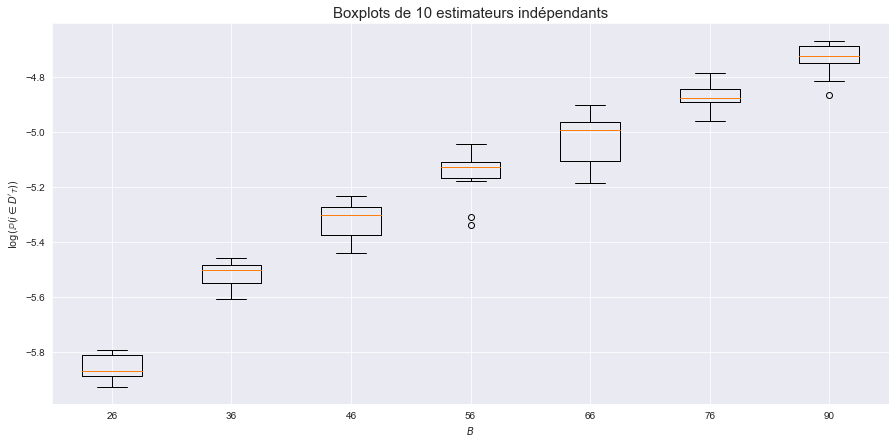

In [382]:
Bs = [26,36,46,56,66,76,90]
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
sigma = 0.4
S0 = 100
Stocks = []
pbar = tqdm(total=len(Bs))
for B in Bs:
    Stocks.append(estimationIPS_ind_Loss(S0,B,sigma,n,M,False)[:,1])
    pbar.update(1)
pbar.close()

Stocks = np.log(np.transpose(np.array(Stocks)))

plt.figure(figsize=(15,7))
plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
plt.xlabel(r'$B$')
plt.ylabel(r"$\log(\mathbb{P}(i \in D'_T))$")
plt.boxplot(Stocks[:, 0:len(Bs)], positions=range(1,len(Bs)+1),labels = Bs)
plt.show()


Pour k =  0
Probabilité de défaut par MC                       p =  1.0
Probabilité de défaut par IPS (traj décroissantes) p =  1.3021587554709355
Probabilité de défaut par IPS (traj basses)        p =  0.5822321632314782


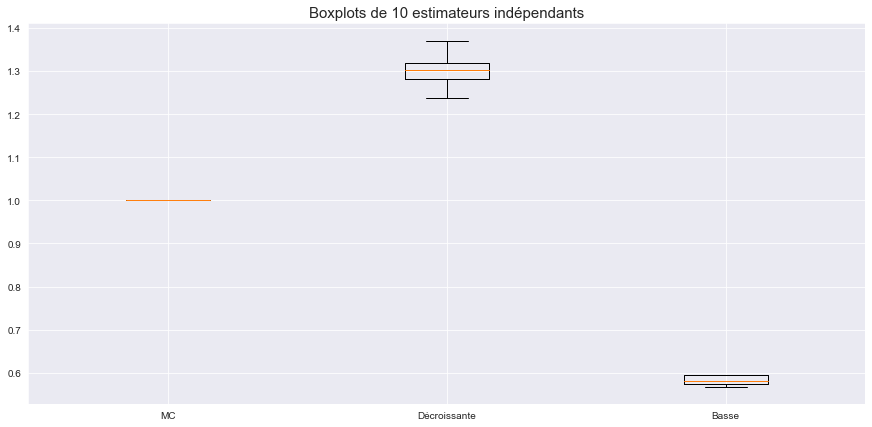

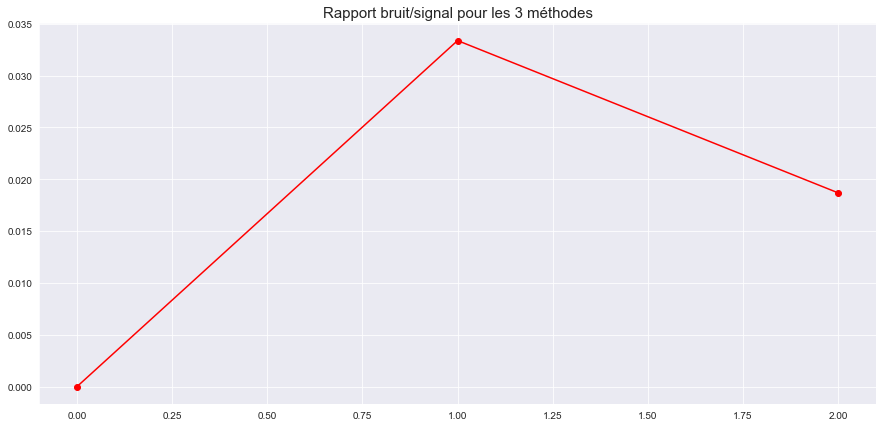

Pour k =  1
Probabilité de défaut par MC                       p =  0.11259999999999999
Probabilité de défaut par IPS (traj décroissantes) p =  0.1647245754315137
Probabilité de défaut par IPS (traj basses)        p =  0.07717873394687468


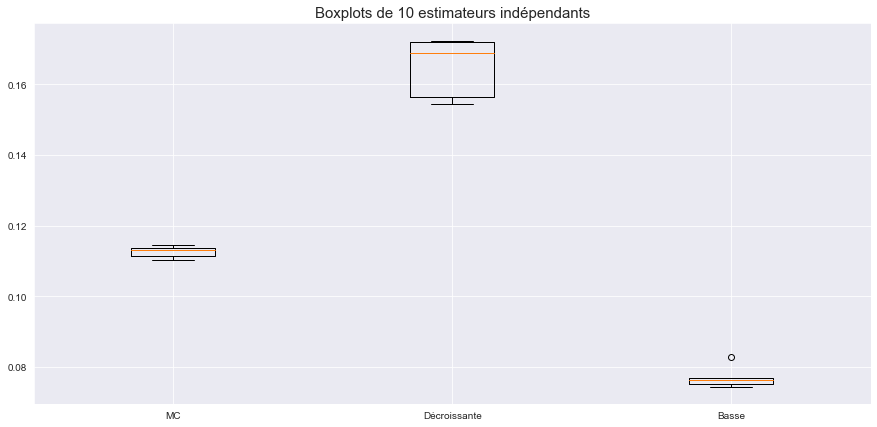

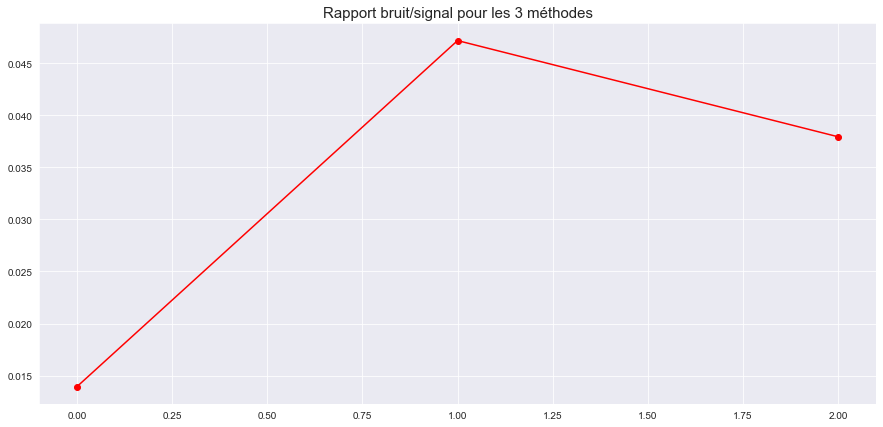

Pour k =  2
Probabilité de défaut par MC                       p =  0.0059
Probabilité de défaut par IPS (traj décroissantes) p =  0.009890673377778953
Probabilité de défaut par IPS (traj basses)        p =  0.0045699043890347416


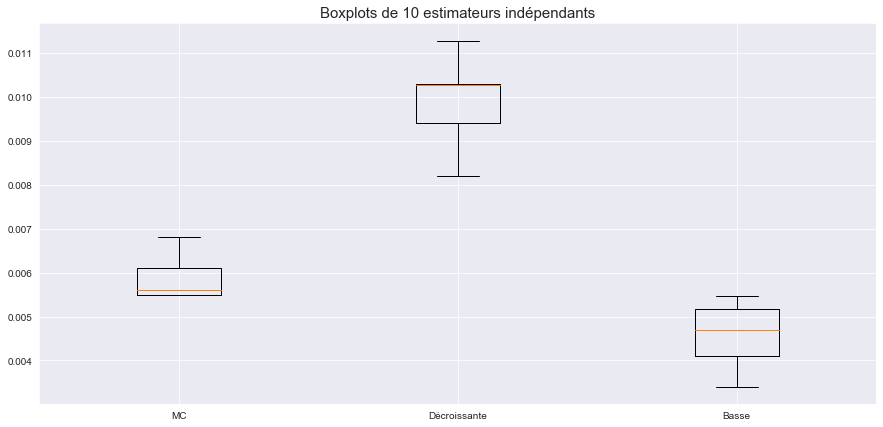

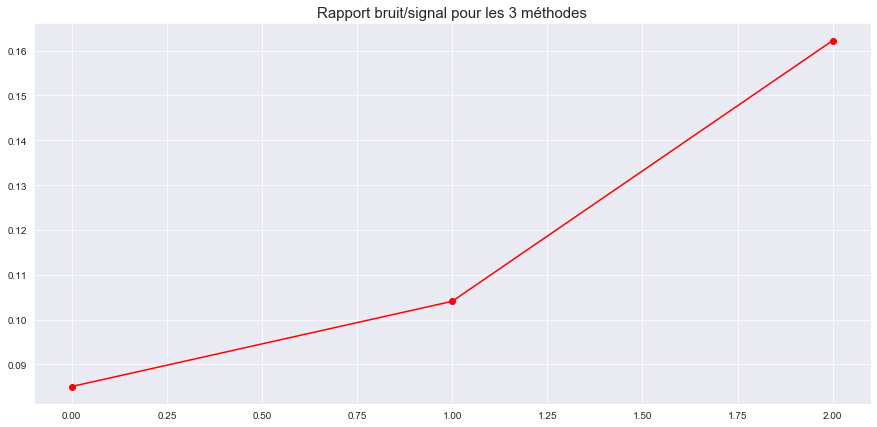

Pour k =  3
Probabilité de défaut par MC                       p =  0.0001
Probabilité de défaut par IPS (traj décroissantes) p =  0.0005734225398875501
Probabilité de défaut par IPS (traj basses)        p =  0.00022072219086241517


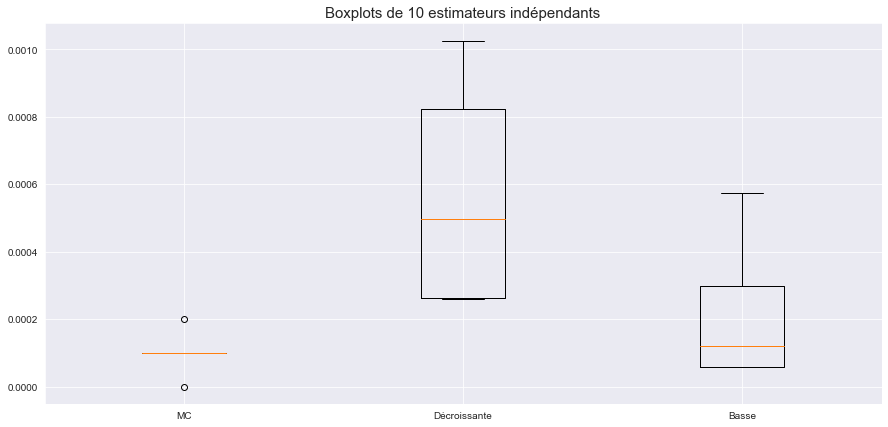

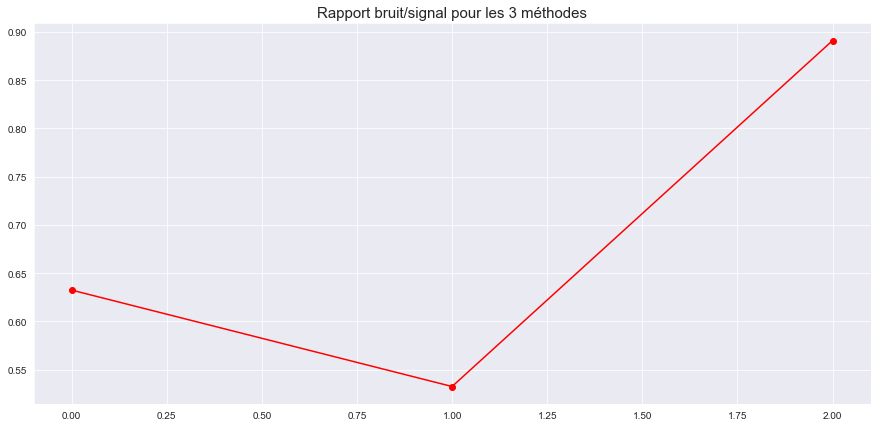

Pour k =  4
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  2.4766910636489006e-05
Probabilité de défaut par IPS (traj basses)        p =  1.1875034909981987e-05


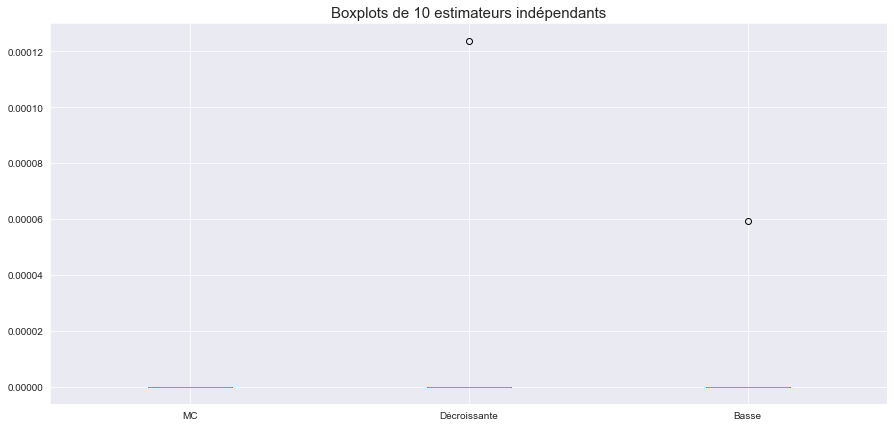

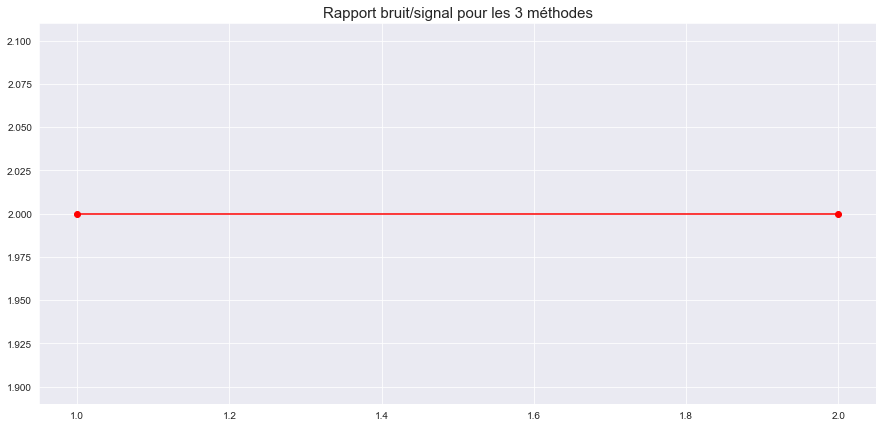

Pour k =  5
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


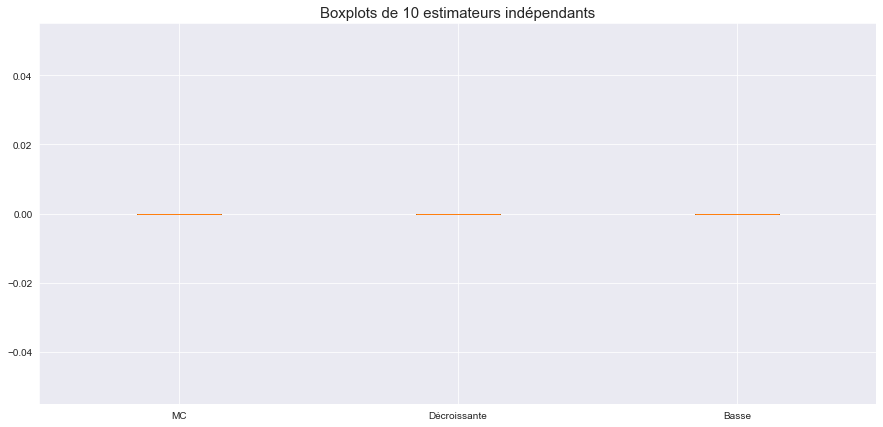

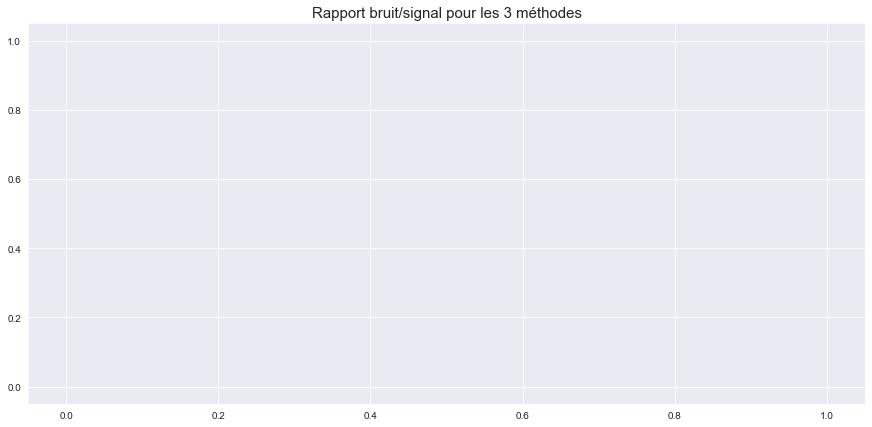

Pour k =  6
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


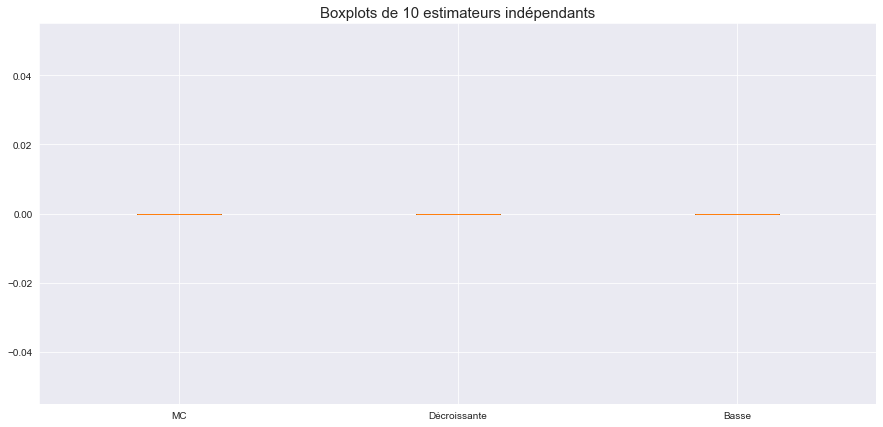

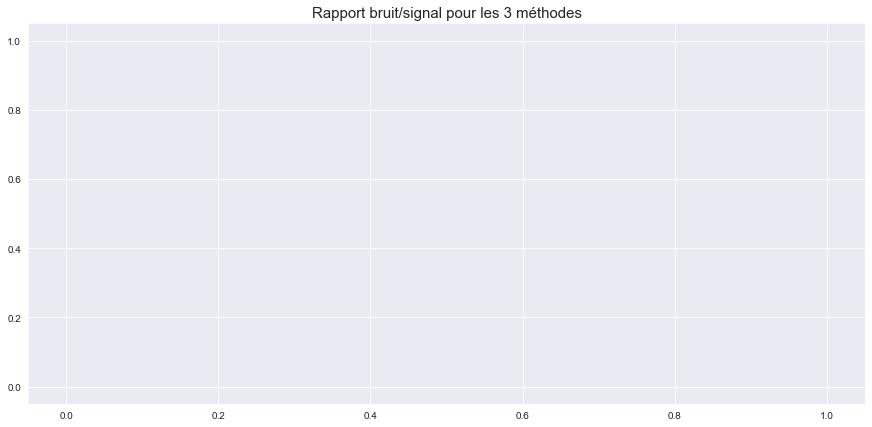

Pour k =  7
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


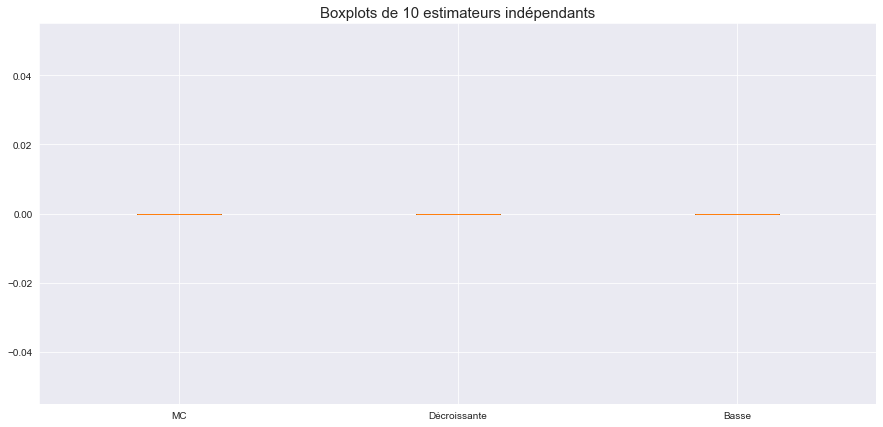

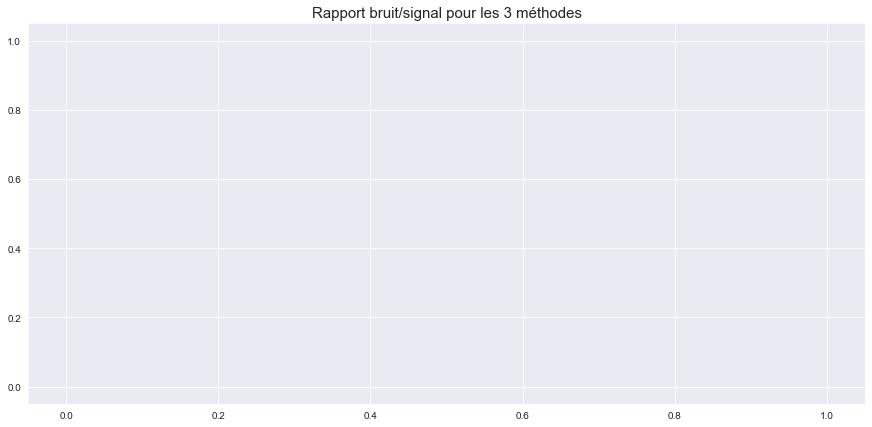

Pour k =  8
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


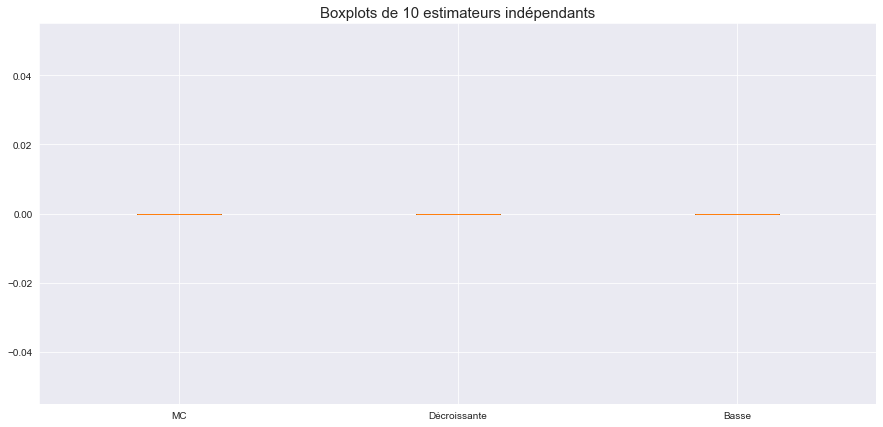

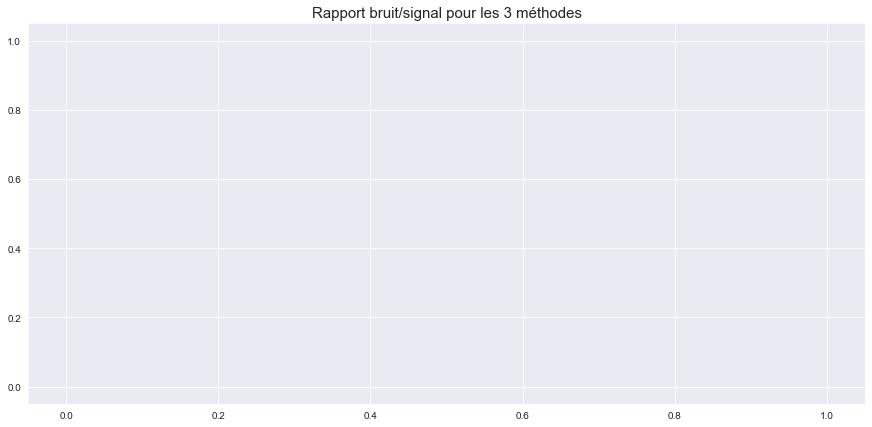

Pour k =  9
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


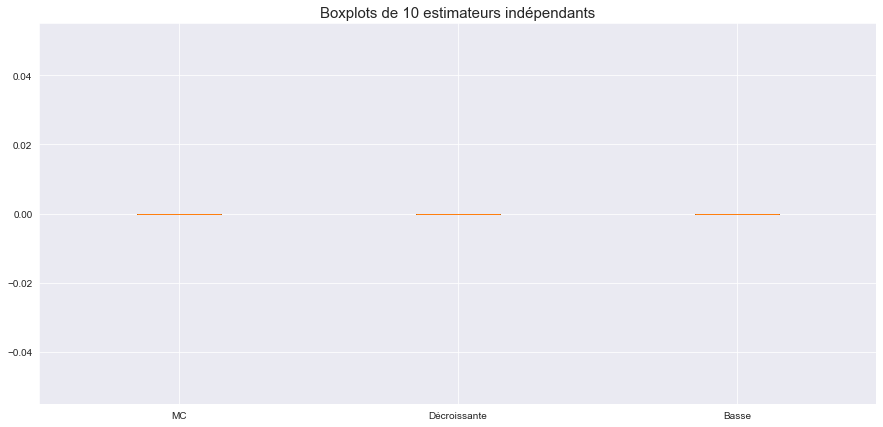

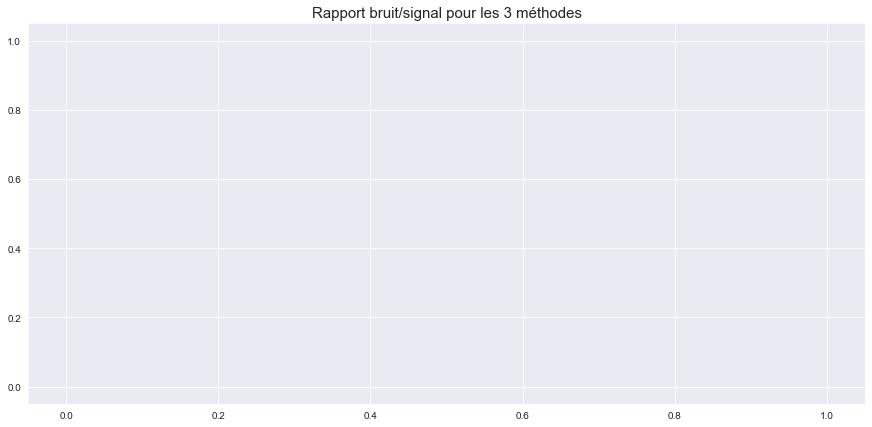

'\n# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)\nplt.figure(figsize=(15,7))\nplt.title("Une trajectoire de l\'estimateur MC naïf en fonction de M")\n\n#Exemple de trajectoire pour MC\nY = np.random.randn(M, n)*(1/np.sqrt(n))\nZ = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)\nestim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)\n\nplt.plot(np.arange(1,M+1), estim_mc, color=\'b\', label="Trajectoire estimateur MC")\nplt.xlabel(\'M\', fontsize=12)\nplt.legend(loc="best", fontsize=12)\nplt.show()\n'

In [886]:
'''
En utilisant les potentiels de minimisation du maximum
'''

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline


N = 10

def meanMat(N,S0,B,sigma,n,M):
    return np.array([[[(1/sigma)*(np.log(B/S0)+0.5*sigma*sigma*(t/n)) for t in range(1,n+1)]  for j in range(N)]for i in range(M)])

def estimationIPS_ind_Vect(N,S0,B,sigma,n,M,progress):

    ############################################
    # Boucle sur le nombre de réalisations 
    # indépendantes de l'estimateur, pour M fixé
    ############################################
    NbrIter = 5
    
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    
    a = 3*mean*np.sqrt(n)
    
    # La variable Stock est utilisée pour stocker les tirages des différents
    # estimateurs. Il y a trois colonnes, car nous simulons trois estimateurs :
    # + un Monte-Carlo naïf avec M points, 
    # + l'algo de sélection-mutation avec sélection haute, 
    # + l'algo de sélection-mutation avec sélection croissante.

    Stock = np.zeros((NbrIter, 3,N+1))
    if progress : 
        pbar = tqdm(total=NbrIter)
    for nn in range(NbrIter):    
        # Tirages de M x n v.a. N(0,1) qui seront utilisées dans toutes les méthodes
        Y = np.random.randn(M, N, n)*(1/np.sqrt(n))
        ###############################
        # Methode Monte-Carlo naïve
        ###############################

        # M réalisations de X_n : M tirages de gaussiennes N(0,n) i.i.d.
        G = np.sum(np.sum(np.cumsum(Y,axis=2)<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N):
            estim_MC = np.mean(G >= k)
            # Stockage des NbrIter estimateurs MC naïfs
            Stock[nn, 0,k] = estim_MC
        ###############################################################################
        ## En pondérant les trajectoires hautes : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = float(a)/(n+1)

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, N,n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, :,1] = Y[:, :,0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * (np.amax(X[:,:,p],axis=1)  - np.amax(X[:,:,p-1],axis=1)) )

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = np.copy(X[indices, :,:])

            # Etape de mutation
            X[:,:, p+1] = X[:,:, p] + Y[:,:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G = np.sum(np.sum(X[:,:,1:]<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N+1):
            estim_IS = np.mean(G >= k)
            facteur_1 = np.mean( estim_IS * np.exp(-la * np.amax(X[:,:,-1],axis=1)))

            estimateur = facteur_1 * estim_const_normalisation

            # Stockage des NbrIter estimateurs
            Stock[nn, 1,k] = estimateur
        ###############################################################################
        ## En pondérant les trajectoires basses : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = 2*a/(n*(n-1))

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M,N, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, :,1] = Y[:,:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * np.amax(X[:,:,p],axis=1))

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = np.copy(X[indices, :,:])

            # Etape de mutation
            X[:,:, p+1] = X[:,:, p] + Y[:,:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G = np.sum(np.sum(X[:,:,1:]<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N):
            estim_IS_2 = np.mean(G >= k)
            facteur_1 = np.mean( estim_IS_2 * np.exp(-la * np.sum(np.amax(X[:,:,:p],axis=1), axis=1) ) )

            estimateur = facteur_1 * estim_const_normalisation
            
            # Stockage des NbrIter estimateurs
            Stock[nn, 2,k] = estimateur
        if progress : 
            pbar.update(1)
    if progress : 
        pbar.close()
    return Stock
    
#########################
# Paramètres du problème
#########################
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
B = 36
sigma = 0.4
S0 = 100

# Calcul des estimations
Stock = estimationIPS_ind_Vect(N,S0,B,sigma,n,M,True)


#######################
## Affichages proposés
#######################
for k in range(N):
    print('Pour k = ',k)
    #Affichage des résultas pour chaque estimateur
    print("Probabilité de défaut par MC                       p = ",str(np.mean(Stock[:,0,k])))
    print("Probabilité de défaut par IPS (traj décroissantes) p = ",str(np.mean(Stock[:,1,k])))
    print("Probabilité de défaut par IPS (traj basses)        p = ",str(np.mean(Stock[:,2,k])))
    # Comparer les boxplots des échantillons de taille NbrIter obtenus pour les 3 estimateurs
    plt.figure(figsize=(15,7))

    plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
    plt.boxplot(Stock[:, 0:3,k], positions=[1,2,3],
                labels = ['MC','Décroissante','Basse'])

    # Comparer les 3 estimateurs par le ratio "écart-type / valeur moyenne", 
    # calculé sur les échantillons de taille NbrIter
    plt.show()
    plt.figure(figsize=(15,7))

    mean_stock = np.mean(Stock[:,:,k], axis=0)

    st_dev = np.std(Stock[:,:,k], axis=0)

    plt.plot(st_dev/mean_stock,'r-o')
    plt.title("Rapport bruit/signal pour les 3 méthodes", fontsize=15)
    plt.show()

'''
# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)
plt.figure(figsize=(15,7))
plt.title("Une trajectoire de l'estimateur MC naïf en fonction de M")

#Exemple de trajectoire pour MC
Y = np.random.randn(M, n)*(1/np.sqrt(n))
Z = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)
estim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)

plt.plot(np.arange(1,M+1), estim_mc, color='b', label="Trajectoire estimateur MC")
plt.xlabel('M', fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.show()
'''


Pour k =  0
Probabilité de défaut par MC                       p =  1.0
Probabilité de défaut par IPS (traj décroissantes) p =  1.002481834762343
Probabilité de défaut par IPS (traj basses)        p =  0.999989212761015


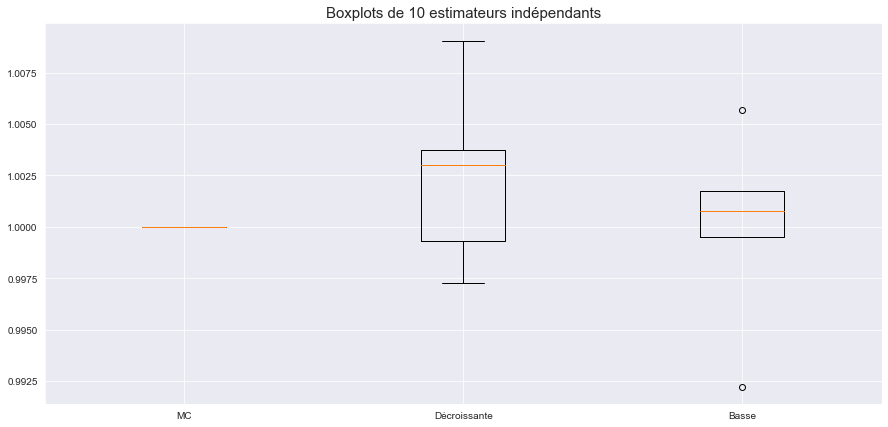

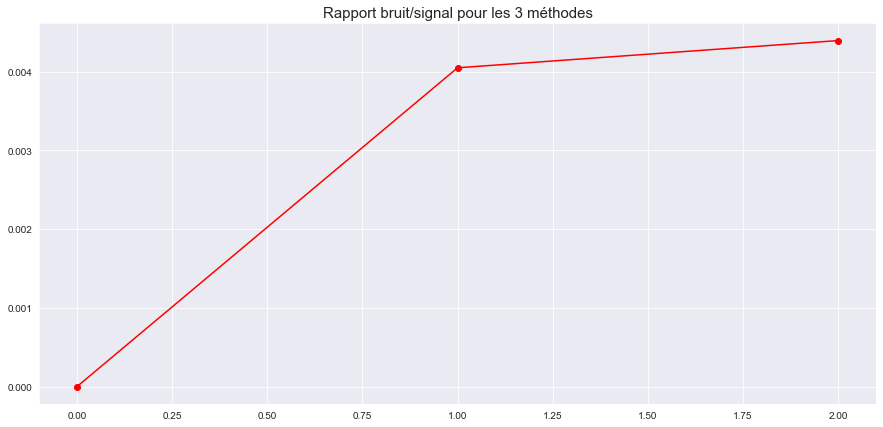

Pour k =  1
Probabilité de défaut par MC                       p =  0.11279999999999998
Probabilité de défaut par IPS (traj décroissantes) p =  0.13087933820797223
Probabilité de défaut par IPS (traj basses)        p =  0.1334867920348394


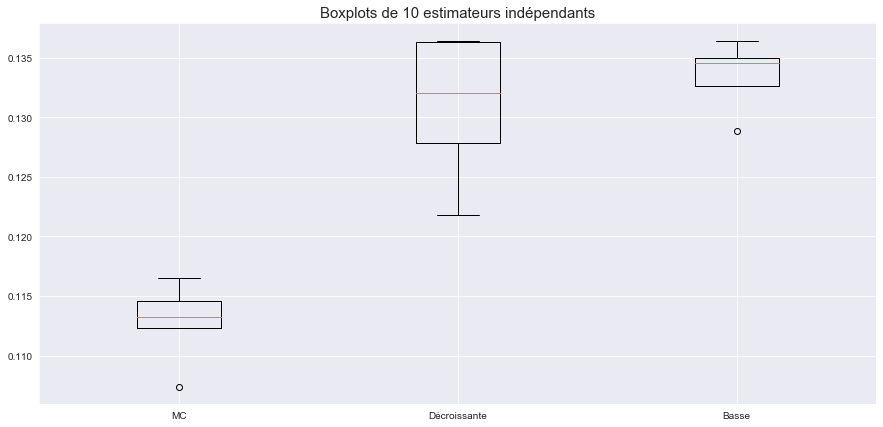

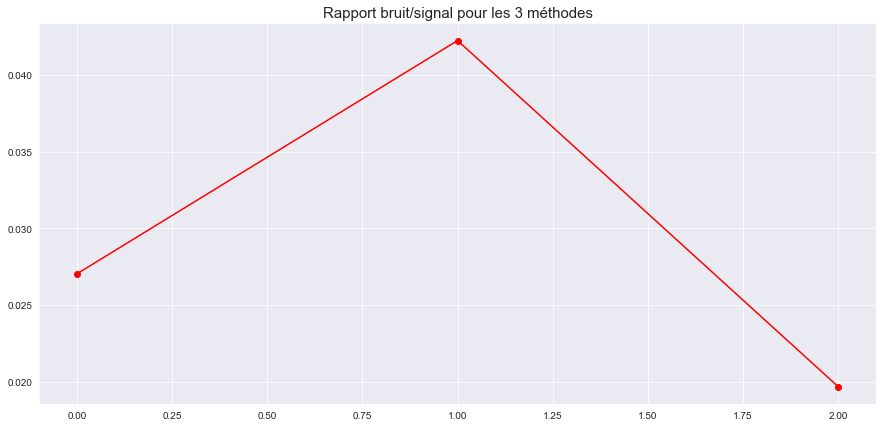

Pour k =  2
Probabilité de défaut par MC                       p =  0.00584
Probabilité de défaut par IPS (traj décroissantes) p =  0.0081014040196781
Probabilité de défaut par IPS (traj basses)        p =  0.008541734107029866


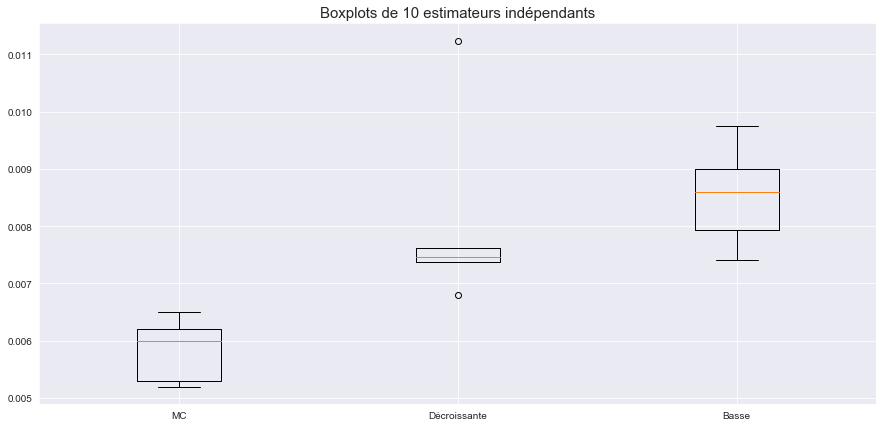

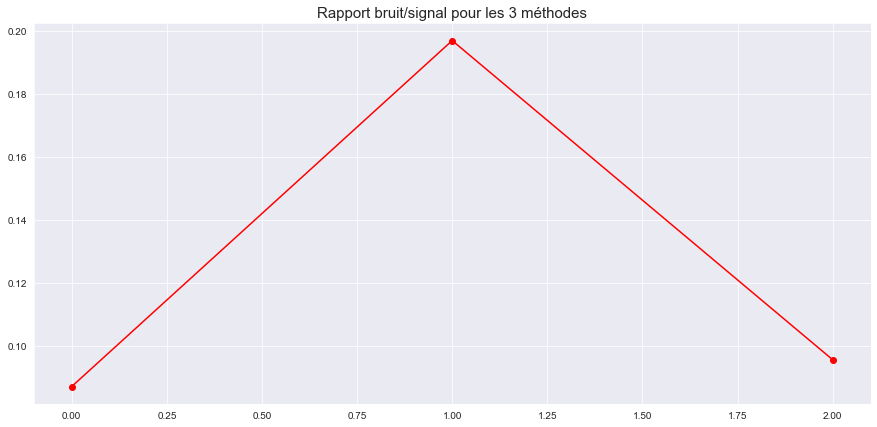

Pour k =  3
Probabilité de défaut par MC                       p =  0.00014
Probabilité de défaut par IPS (traj décroissantes) p =  0.00018055097893117028
Probabilité de défaut par IPS (traj basses)        p =  0.00021981332316847765


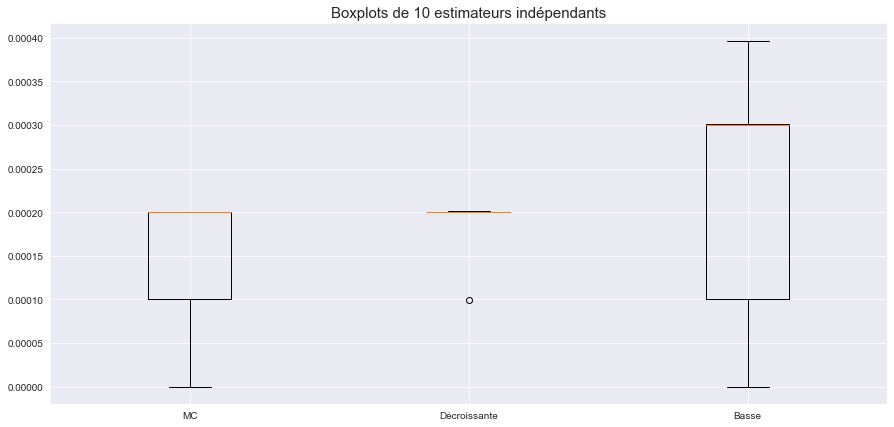

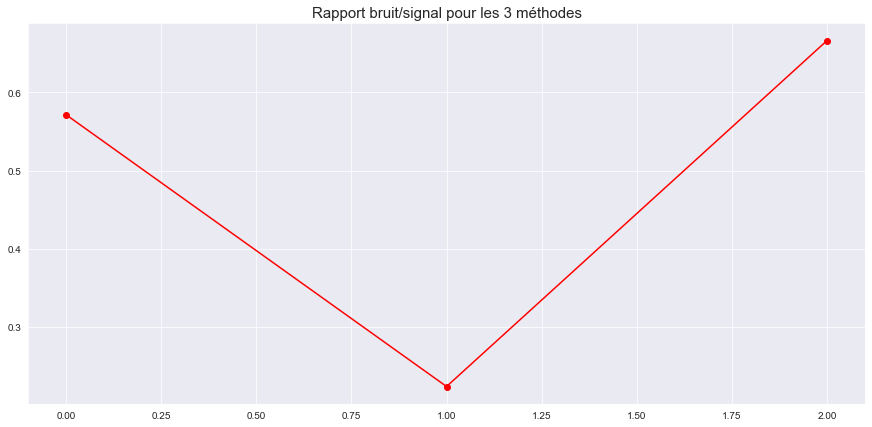

Pour k =  4
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


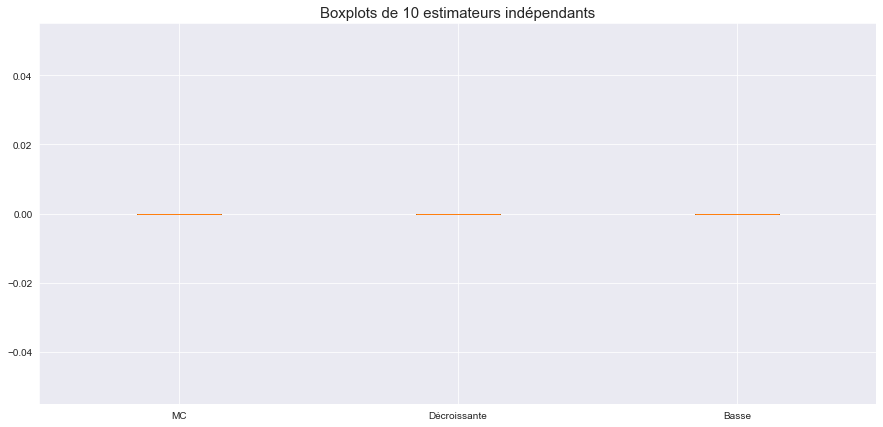

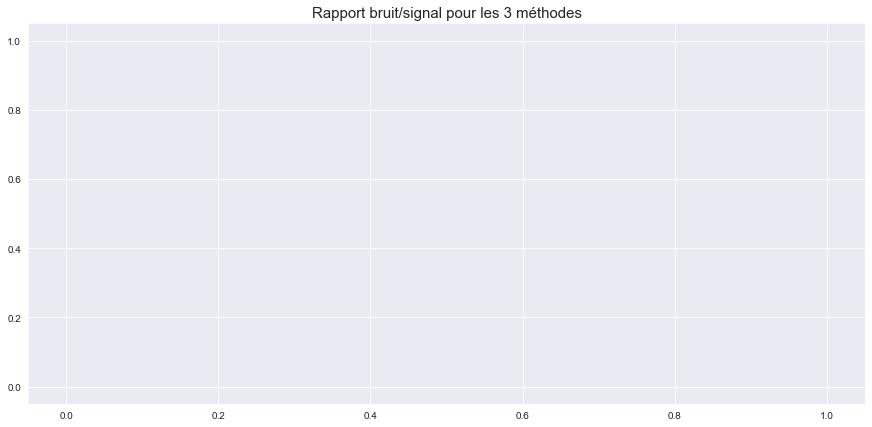

Pour k =  5
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


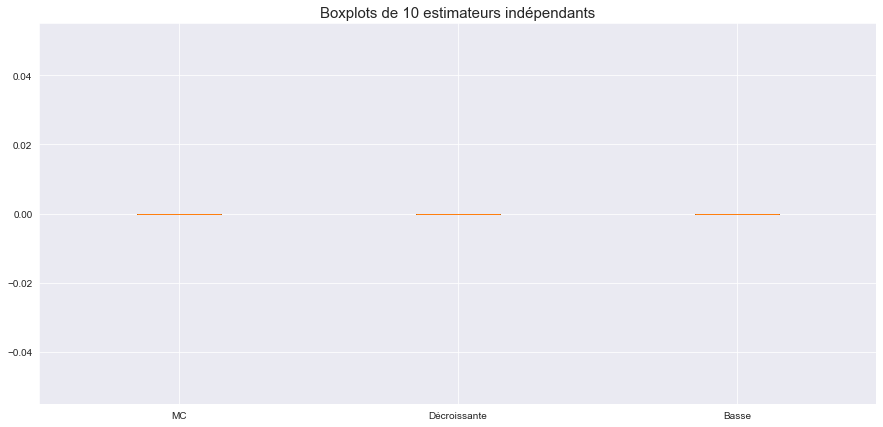

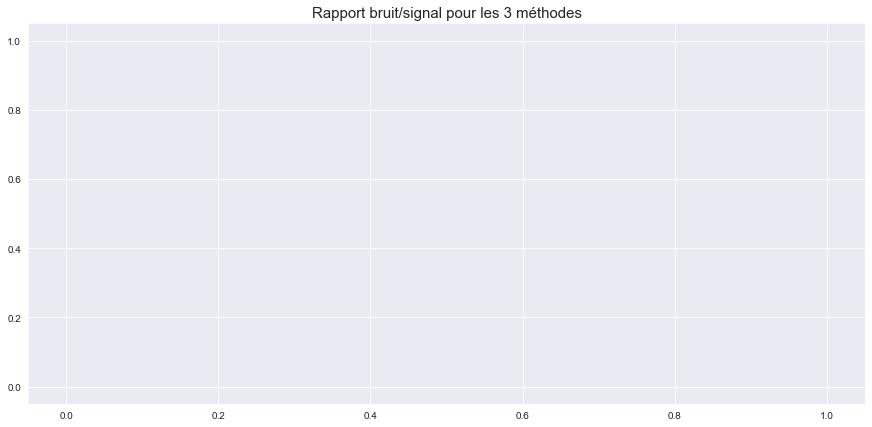

Pour k =  6
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


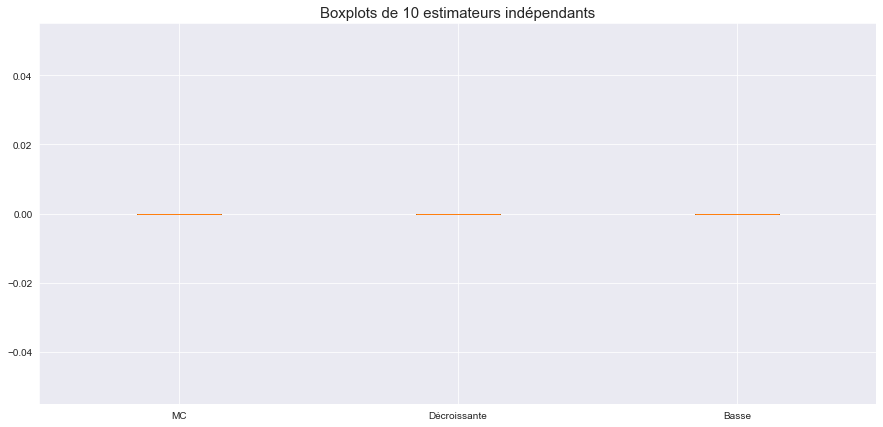

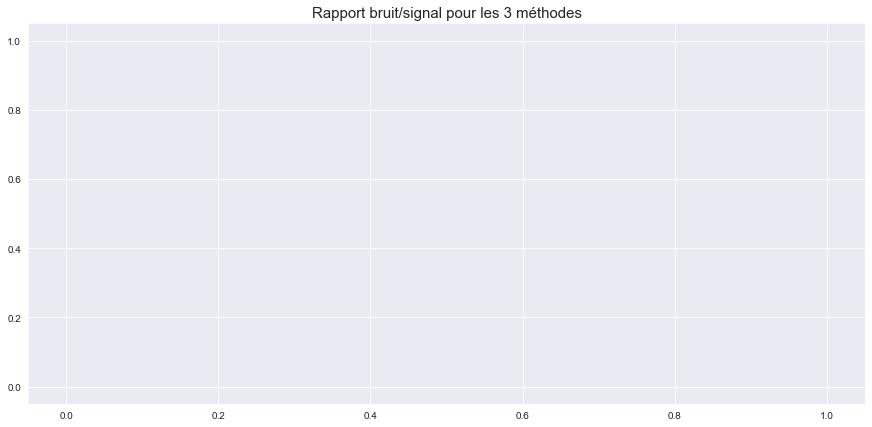

Pour k =  7
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


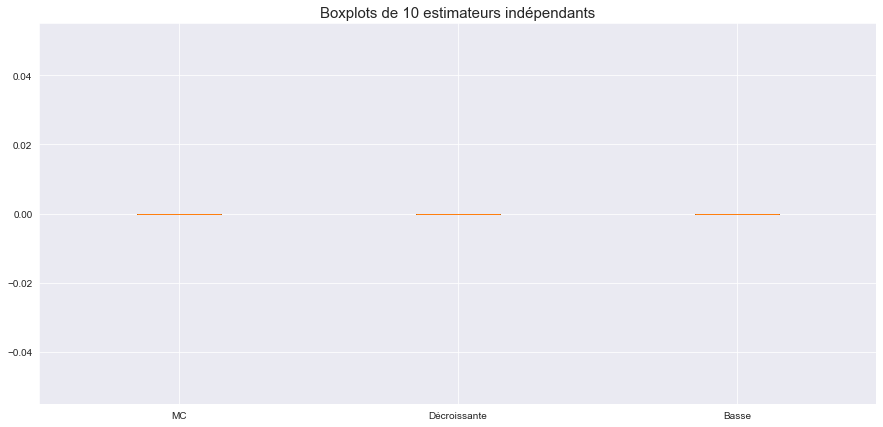

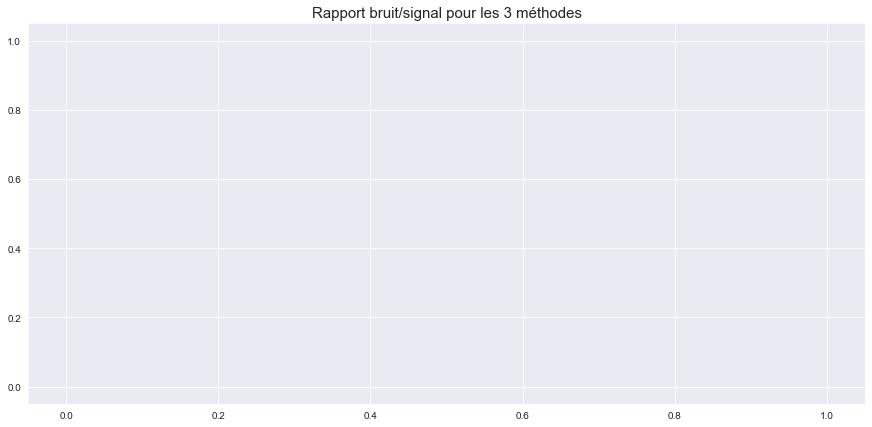

Pour k =  8
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


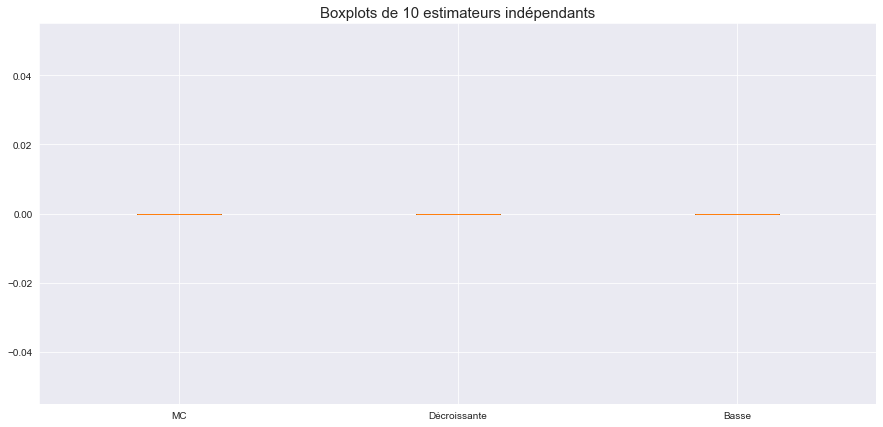

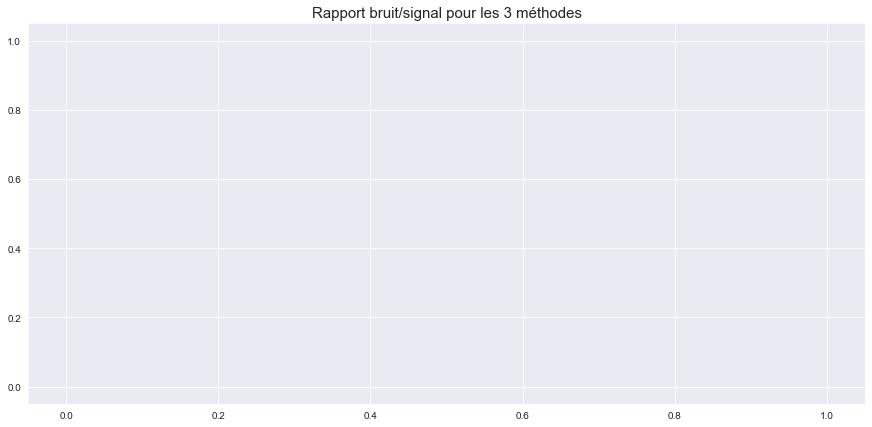

Pour k =  9
Probabilité de défaut par MC                       p =  0.0
Probabilité de défaut par IPS (traj décroissantes) p =  0.0
Probabilité de défaut par IPS (traj basses)        p =  0.0


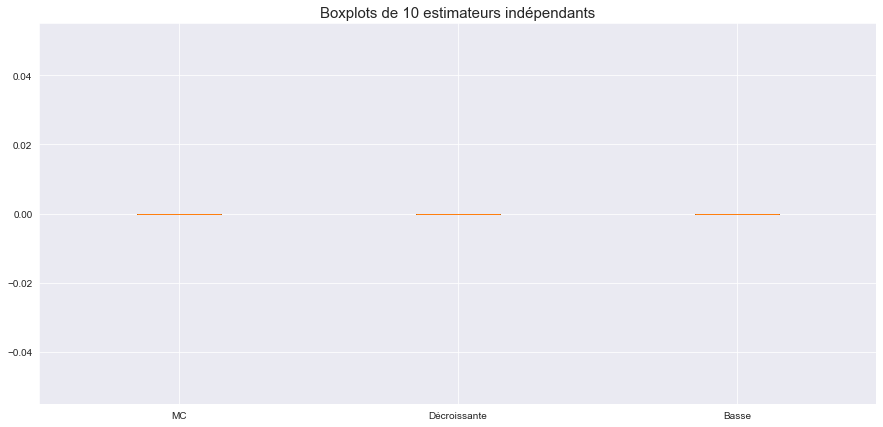

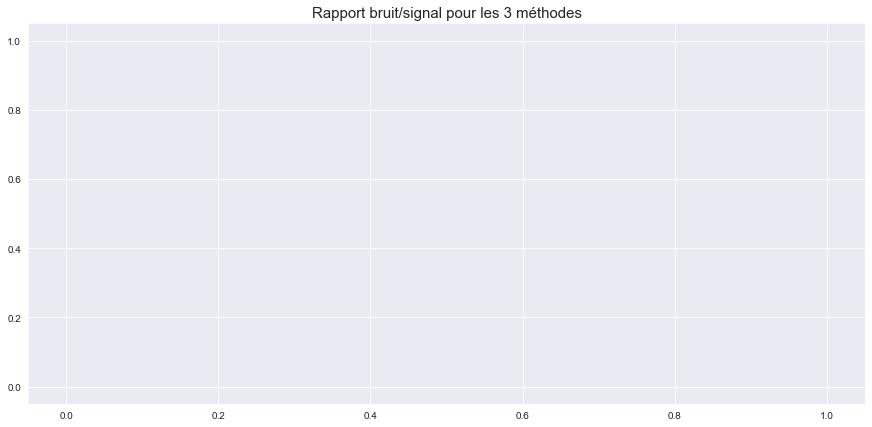

'\n# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)\nplt.figure(figsize=(15,7))\nplt.title("Une trajectoire de l\'estimateur MC naïf en fonction de M")\n\n#Exemple de trajectoire pour MC\nY = np.random.randn(M, n)*(1/np.sqrt(n))\nZ = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)\nestim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)\n\nplt.plot(np.arange(1,M+1), estim_mc, color=\'b\', label="Trajectoire estimateur MC")\nplt.xlabel(\'M\', fontsize=12)\nplt.legend(loc="best", fontsize=12)\nplt.show()\n'

In [884]:
'''
En utilisant les potentiels de minimisation de la moyenne
'''
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline


N = 10

def meanMat(N,S0,B,sigma,n,M):
    return np.array([[[(1/sigma)*(np.log(B/S0)+0.5*sigma*sigma*(t/n)) for t in range(1,n+1)]  for j in range(N)]for i in range(M)])

def estimationIPS_ind_Vect(N,S0,B,sigma,n,M,progress):

    ############################################
    # Boucle sur le nombre de réalisations 
    # indépendantes de l'estimateur, pour M fixé
    ############################################
    NbrIter = 5
    
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    
    a = mean*np.sqrt(n)
    
    # La variable Stock est utilisée pour stocker les tirages des différents
    # estimateurs. Il y a trois colonnes, car nous simulons trois estimateurs :
    # + un Monte-Carlo naïf avec M points, 
    # + l'algo de sélection-mutation avec sélection haute, 
    # + l'algo de sélection-mutation avec sélection croissante.

    Stock = np.zeros((NbrIter, 3,N+1))
    if progress : 
        pbar = tqdm(total=NbrIter)
    for nn in range(NbrIter):    
        # Tirages de M x n v.a. N(0,1) qui seront utilisées dans toutes les méthodes
        Y = np.random.randn(M, N, n)*(1/np.sqrt(n))
        ###############################
        # Methode Monte-Carlo naïve
        ###############################

        # M réalisations de X_n : M tirages de gaussiennes N(0,n) i.i.d.
        G = np.sum(np.sum(np.cumsum(Y,axis=2)<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N):
            estim_MC = np.mean(G >= k)
            # Stockage des NbrIter estimateurs MC naïfs
            Stock[nn, 0,k] = estim_MC
        ###############################################################################
        ## En pondérant les trajectoires hautes : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = float(a)/(n+1)

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, N,n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, :,1] = Y[:, :,0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * (np.mean(X[:,:,p],axis=1)  - np.mean(X[:,:,p-1],axis=1)) )

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = np.copy(X[indices, :,:])

            # Etape de mutation
            X[:,:, p+1] = X[:,:, p] + Y[:,:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G = np.sum(np.sum(X[:,:,1:]<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N+1):
            estim_IS = np.mean(G >= k)
            facteur_1 = np.mean( estim_IS * np.exp(-la * np.mean(X[:,:,-1],axis=1)))

            estimateur = facteur_1 * estim_const_normalisation

            # Stockage des NbrIter estimateurs
            Stock[nn, 1,k] = estimateur
        ###############################################################################
        ## En pondérant les trajectoires basses : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = 2*a/(n*(n-1))

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M,N, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, :,1] = Y[:,:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * np.mean(X[:,:,p],axis=1))

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = np.copy(X[indices, :,:])

            # Etape de mutation
            X[:,:, p+1] = X[:,:, p] + Y[:,:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G = np.sum(np.sum(X[:,:,1:]<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N):
            estim_IS_2 = np.mean(G >= k)
            facteur_1 = np.mean( estim_IS_2 * np.exp(-la * np.sum(np.mean(X[:,:,:p],axis=1), axis=1) ) )

            estimateur = facteur_1 * estim_const_normalisation
            
            # Stockage des NbrIter estimateurs
            Stock[nn, 2,k] = estimateur
        if progress : 
            pbar.update(1)
    if progress : 
        pbar.close()
    return Stock
    
#########################
# Paramètres du problème
#########################
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
B = 36
sigma = 0.4
S0 = 100

# Calcul des estimations
Stock = estimationIPS_ind_Vect(N,S0,B,sigma,n,M,True)


#######################
## Affichages proposés
#######################
for k in range(N):
    print('Pour k = ',k)
    #Affichage des résultas pour chaque estimateur
    print("Probabilité de défaut par MC                       p = ",str(np.mean(Stock[:,0,k])))
    print("Probabilité de défaut par IPS (traj décroissantes) p = ",str(np.mean(Stock[:,1,k])))
    print("Probabilité de défaut par IPS (traj basses)        p = ",str(np.mean(Stock[:,2,k])))
    # Comparer les boxplots des échantillons de taille NbrIter obtenus pour les 3 estimateurs
    plt.figure(figsize=(15,7))

    plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
    plt.boxplot(Stock[:, 0:3,k], positions=[1,2,3],
                labels = ['MC','Décroissante','Basse'])

    # Comparer les 3 estimateurs par le ratio "écart-type / valeur moyenne", 
    # calculé sur les échantillons de taille NbrIter
    plt.show()
    plt.figure(figsize=(15,7))

    mean_stock = np.mean(Stock[:,:,k], axis=0)

    st_dev = np.std(Stock[:,:,k], axis=0)

    plt.plot(st_dev/mean_stock,'r-o')
    plt.title("Rapport bruit/signal pour les 3 méthodes", fontsize=15)
    plt.show()

'''
# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)
plt.figure(figsize=(15,7))
plt.title("Une trajectoire de l'estimateur MC naïf en fonction de M")

#Exemple de trajectoire pour MC
Y = np.random.randn(M, n)*(1/np.sqrt(n))
Z = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)
estim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)

plt.plot(np.arange(1,M+1), estim_mc, color='b', label="Trajectoire estimateur MC")
plt.xlabel('M', fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.show()
'''

In [ ]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline


N = 10

def meanMat(N,S0,B,sigma,n,M):
    return np.array([[[(1/sigma)*(np.log(B/S0)+0.5*sigma*sigma*(t/n)) for t in range(1,n+1)]  for j in range(N)]for i in range(M)])

def estimationIPS_ind_Vect(N,S0,B,sigma,n,M,progress):

    ############################################
    # Boucle sur le nombre de réalisations 
    # indépendantes de l'estimateur, pour M fixé
    ############################################
    NbrIter = 5
    
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    
    a = mean*np.sqrt(n)
    
    # La variable Stock est utilisée pour stocker les tirages des différents
    # estimateurs. Il y a trois colonnes, car nous simulons trois estimateurs :
    # + un Monte-Carlo naïf avec M points, 
    # + l'algo de sélection-mutation avec sélection haute, 
    # + l'algo de sélection-mutation avec sélection croissante.

    Stock = np.zeros((NbrIter, 3,N+1))
    if progress : 
        pbar = tqdm(total=NbrIter)
    for nn in range(NbrIter):    
        # Tirages de M x n v.a. N(0,1) qui seront utilisées dans toutes les méthodes
        Y = np.random.randn(M, N, n)*(1/np.sqrt(n))
        ###############################
        # Methode Monte-Carlo naïve
        ###############################

        # M réalisations de X_n : M tirages de gaussiennes N(0,n) i.i.d.
        G = np.sum(np.sum(np.cumsum(Y,axis=2)<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N):
            estim_MC = np.mean(G >= k)
            # Stockage des NbrIter estimateurs MC naïfs
            Stock[nn, 0,k] = estim_MC
        ###############################################################################
        ## En pondérant les trajectoires hautes : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = float(a)/(n+1)

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M, N,n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, :,1] = Y[:, :,0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * (np.mean(X[:,:,p],axis=1)  - np.mean(X[:,:,p-1],axis=1)) )

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = np.copy(X[indices, :,:])

            # Etape de mutation
            X[:,:, p+1] = X[:,:, p] + Y[:,:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G = np.sum(np.sum(X[:,:,1:]<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N+1):
            estim_IS = np.mean(G >= k)
            facteur_1 = np.mean( estim_IS * np.exp(-la * np.mean(X[:,:,-1],axis=1)))

            estimateur = facteur_1 * estim_const_normalisation

            # Stockage des NbrIter estimateurs
            Stock[nn, 1,k] = estimateur
        ###############################################################################
        ## En pondérant les trajectoires basses : Estimation via G(X)=e^{la X_p}
        ###############################################################################
        la = 2*a/(n*(n-1))

        # X stocke les M trajectoires de la chaîne qui sera obtenue à l'étape finale de l'algorithme
        # On choisit des array de longueur n+1 pour stocker la trajectoire (X_0, X_1,..., X_n), même si
        # on ne se servira pas de la première valeur X_0
        X = np.zeros((M,N, n+1))

        # Initialisation de X : X0 = 0 et X1 suit une loi N(0,1)
        X[:, :,1] = Y[:,:, 0]

        # Initialisation de la constante de normalisation
        estim_const_normalisation = 1

        for p in range(1, n):
            # Calcul des M poids
            G = np.exp(la * np.mean(X[:,:,p],axis=1))

            # Mise à jour de la constante de normalisation 
            estim_const_normalisation = estim_const_normalisation * np.mean(G)

            # Tirages des indices de sélection
            probas = G / np.sum(G)
            indices = np.random.choice(np.arange(M), size = M, p = probas)

            # Etape de sélection
            X = np.copy(X[indices, :,:])

            # Etape de mutation
            X[:,:, p+1] = X[:,:, p] + Y[:,:, p]

        #######################################################
        # A la fin de la boucle sur p : calcul de l'estimateur 
        #######################################################
        G = np.sum(np.sum(X[:,:,1:]<= meanMat(N,S0,B,sigma,n,M), axis=2) > 0,axis=1)
        for k in range(N):
            estim_IS_2 = np.mean(G >= k)
            facteur_1 = np.mean( estim_IS_2 * np.exp(-la * np.sum(np.mean(X[:,:,:p],axis=1), axis=1) ) )

            estimateur = facteur_1 * estim_const_normalisation
            
            # Stockage des NbrIter estimateurs
            Stock[nn, 2,k] = estimateur
        if progress : 
            pbar.update(1)
    if progress : 
        pbar.close()
    return Stock
    
#########################
# Paramètres du problème
#########################
# horizon temporel
n = 12
# nombre de particules à chaque itération
M = int(1E4)
#  définition du seuil
B = 36
sigma = 0.4
S0 = 100

# Calcul des estimations
Stock = estimationIPS_ind_Vect(N,S0,B,sigma,n,M,True)


#######################
## Affichages proposés
#######################
for k in range(N):
    print('Pour k = ',k)
    #Affichage des résultas pour chaque estimateur
    print("Probabilité de défaut par MC                       p = ",str(np.mean(Stock[:,0,k])))
    print("Probabilité de défaut par IPS (traj décroissantes) p = ",str(np.mean(Stock[:,1,k])))
    print("Probabilité de défaut par IPS (traj basses)        p = ",str(np.mean(Stock[:,2,k])))
    # Comparer les boxplots des échantillons de taille NbrIter obtenus pour les 3 estimateurs
    plt.figure(figsize=(15,7))

    plt.title("Boxplots de " + str(NbrIter) +" estimateurs indépendants", fontsize=15)
    plt.boxplot(Stock[:, 0:3,k], positions=[1,2,3],
                labels = ['MC','Décroissante','Basse'])

    # Comparer les 3 estimateurs par le ratio "écart-type / valeur moyenne", 
    # calculé sur les échantillons de taille NbrIter
    plt.show()
    plt.figure(figsize=(15,7))

    mean_stock = np.mean(Stock[:,:,k], axis=0)

    st_dev = np.std(Stock[:,:,k], axis=0)

    plt.plot(st_dev/mean_stock,'r-o')
    plt.title("Rapport bruit/signal pour les 3 méthodes", fontsize=15)
    plt.show()

'''
# On peut observer une trajectoire du Monte-Carlo naïf (si cela est possible)
plt.figure(figsize=(15,7))
plt.title("Une trajectoire de l'estimateur MC naïf en fonction de M")

#Exemple de trajectoire pour MC
Y = np.random.randn(M, n)*(1/np.sqrt(n))
Z = np.sum(np.cumsum(Y,axis=1)<= meanVect(S0,B,sigma,n,M), axis=1)
estim_mc = np.cumsum(Z>0,dtype=float)/np.arange(1,M+1)

plt.plot(np.arange(1,M+1), estim_mc, color='b', label="Trajectoire estimateur MC")
plt.xlabel('M', fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.show()
'''